# Linear Regression of the Counter-Current Heat Exchanger Model
#### Khaled Aleikish and Bernt Lie
#### University of South-Eastern Norway
#### Porsgrunn, April 2020

## Preliminaries
### Packages

In [1]:
using DifferentialEquations
using LaTeXStrings
using Plots; pyplot(); # here, pyplot is used as a back-end to the Plots API
using Plots.PlotMeasures
using BenchmarkTools
using Combinatorics
using ProgressMeter
using DataFrames
using GLM
using LinearAlgebra
using StatsBase

|Package|Link|
|:---|:------------|
|DifferentialEquations|https://github.com/SciML/DiffEqDocs.jl/blob/master/docs/src/index.md|
|LaTeXStrings|https://github.com/stevengj/LaTeXStrings.jl|
|Plots|https://github.com/JuliaPlots/Plots.jl|
|PyPlot|https://github.com/JuliaPy/PyPlot.jl|
|BenchmarkTools|https://github.com/JuliaCI/BenchmarkTools.jl|
|Combinatorics|https://github.com/JuliaMath/Combinatorics.jl|
|ProgressMeter|https://github.com/timholy/ProgressMeter.jl|
|DataFrames|https://github.com/JuliaData/DataFrames.jl|
|GLM|https://github.com/JuliaStats/GLM.jl|
|LinearAlgebra|https://github.com/JuliaLang/julia/blob/master/stdlib/LinearAlgebra/docs/src/index.md|
|StatsBase|https://github.com/JuliaStats/StatsBase.jl|

### Utility parameters

In [2]:
# Plot parameters
LW1 = 2.5
LW2 = 1.5
LW3 = 1
LS1 = :solid
LS2 = :dot
LS3 = :dash
LS4 = :dashdot
LA1 = 1
LA2 = 0.7
LA3 = 0.4
# File system paths
#
# Figures are stored in this path.
Figpath = "C:\\Users\\kolds\\Dropbox\\Master's_Thesis\\MSc_Report_Lyx\\fig\\Simulation_Results\\Jupyter_Notebook_3\\" 
;

### Utility functions

In [3]:
# BL Utility functions
#
# Matrix to vector
function mat2vec(M)
    return [M[:,i] for i in 1:size(M,2)]
end
#
# Building polynomial basis for regression
phi_m(x;n=1) = collect(Iterators.flatten((prod(y) for y in with_replacement_combinations(x, i)) for i = 0:n));
;

In [4]:
# This function measure of goodness-of-fit using the adjusted R-squared and using the standard error of the regression. RMSE is also computed, but not used.
function goodness_of_fit(TTAgrid,TTNgrid,i)
    Std_Error_Array =  Array{Float64}(undef, i,4);
    R_bar_Array =  Array{Float64}(undef, i,3);
    RMSE_Array = Array{Float64}(undef, i,3);
    for order in 1:i
        X = (phi_m.(mat2vec(TTAgrid);n=order) |> x -> reduce(hcat,x))'  
        Y = TTNgrid';
        β = X\Y
        ŷ = X*β;
        df_RSS = (ngrid - size(β)[1])
        df_TSS = (ngrid - 1)
        #
        RSS_1 = norm(Y[:,1].-ŷ[:,1])
        TSS_1 = norm(Y[:,1].-mean(ŷ[:,1]))     
        Std_Error_1 = sqrt(RSS_1/df_RSS)
        R_squared_1 = 1 - (RSS_1/TSS_1)
        R_bar_1 = 1 - (1-R_squared_1)*(df_TSS/df_TSS)
        #
        RSS_2 = norm(Y[:,2].-ŷ[:,2])
        TSS_2 = norm(Y[:,2].-mean(ŷ[:,2]))  
        Std_Error_2 = sqrt(RSS_2/df_RSS)
        R_squared_2 = 1 - (RSS_2/TSS_2)
        R_bar_2 = 1 - (1-R_squared_2)*(df_TSS/df_TSS)
        #
        Std_Error_Array[order,1] = order
        Std_Error_Array[order,2] = df_RSS
        Std_Error_Array[order,3] = Std_Error_1
        Std_Error_Array[order,4] = Std_Error_2
        R_bar_Array[order,1] = order        
        R_bar_Array[order,2] = R_bar_1
        R_bar_Array[order,3] = R_bar_2
        #
        RMSE_Array[order,1]=order
        RMSE_Array[order,2]=RMSE(Y[:,1],ŷ[:,1])
        RMSE_Array[order,3]=RMSE(Y[:,2],ŷ[:,2])
        #
#         println("Order ", order,"\nThe standard error of the regression for Y1: ", Std_Error_1,"\nThe standard error of the regression for Y2: ", Std_Error_2)
#         println("on ", df_RSS," degrees of freedom")
#         println("\nThe adjusted coefficient of determination for Y1: ", R_bar_1,"\nThe adjusted coefficient of determination for for Y2: ",R_bar_2)
#         println()
    end
    return [Std_Error_Array R_bar_Array RMSE_Array]
end 
RMSE(Y,ŷ) = sqrt(sum((ŷ .- Y).^2)/length(Y));
;

In [5]:
# This function runs the Holdout method multiple times and returns an average of the standard error of the regression, RMSE, and R-bar
function multiple_Holdout(TTAgrid,TTNgrid,order,ngrid,ratio,j)
    Std_Error_Array =  Array{Float64}(undef, j,3);
    R_bar_Array =  Array{Float64}(undef, j,2);
    RMSE_Array =  Array{Float64}(undef, j,2);
    for v in 1:j
        #
        # Preparing the data set for sampling
        #
        Twh_A_N =(hcat(TTAgrid'[:,1],TTNgrid'[:,1]))'
        Tac_A_N =(hcat(TTAgrid'[:,2],TTNgrid'[:,2]))'
        #
        # Constructing training & testing samples indices
        #
        Train_index =  sort!(StatsBase.sample(1:ngrid, convert(Int64, round(ratio*ngrid)), replace=false))
        #
        Test_index = [i for i in 1:ngrid]
        for i in Train_index
            k = findall(x->x==i,Test_index)
            Test_index = Test_index[1:end .!= k, 1]
        end
        #
        # Constructing training & testing samples
        #
        Train_Sample_Twh = Twh_A_N[:,Train_index[:]]
        Train_Sample_Tac = Tac_A_N[:,Train_index[:]]
        Test_Sample_Twh = Twh_A_N[:,Test_index[:]]
        Test_Sample_Tac = Tac_A_N[:,Test_index[:]]
        #
        # Reconstructing TTAgrid & TTNgrid from samples
        #
        TTAgrid_Train_Sample=[Train_Sample_Twh[1,:] Train_Sample_Tac[1,:]]'
        TTNgrid_Train_Sample=[Train_Sample_Twh[2,:] Train_Sample_Tac[2,:]]'
        TTAgrid_Test_Sample=[Test_Sample_Twh[1,:] Test_Sample_Tac[1,:]]'
        TTNgrid_Test_Sample=[Test_Sample_Twh[2,:] Test_Sample_Tac[2,:]]'
        #
        # Linear regression
        #
        X = (phi_m.(mat2vec(TTAgrid_Train_Sample);n=order) |> x -> reduce(hcat,x))'  
        Y = TTNgrid_Train_Sample';
        β = X\Y
        #
        # Prediction
        #
        X_test = (phi_m.(mat2vec(TTAgrid_Test_Sample);n=order) |> x -> reduce(hcat,x))'
        ŷ = X_test*β
        Y_test = TTNgrid_Test_Sample'
        #
        # measure of goodness-of-fit using the adjusted R-squared, the standard error of the regression, and RMSE.
        #
        df_RSS = (length(Test_index) - size(β)[1])
        df_TSS = (length(Test_index) - 1)
        #
        RSS_1 = norm(Y_test[:,1].-ŷ[:,1])
        TSS_1 = norm(Y_test[:,1].-mean(ŷ[:,1]))     
        Std_Error_1 = sqrt(RSS_1/df_RSS)
        R_squared_1 = 1 - (RSS_1/TSS_1)
        R_bar_1 = 1 - (1-R_squared_1)*(df_TSS/df_TSS)
        #
        RSS_2 = norm(Y_test[:,2].-ŷ[:,2])
        TSS_2 = norm(Y_test[:,2].-mean(ŷ[:,2]))  
        Std_Error_2 = sqrt(RSS_2/df_RSS)
        R_squared_2 = 1 - (RSS_2/TSS_2)
        R_bar_2 = 1 - (1-R_squared_2)*(df_TSS/df_TSS)
        #
        #
        #
        Std_Error_Array[v,1] = df_RSS
        Std_Error_Array[v,2] = Std_Error_1
        Std_Error_Array[v,3] = Std_Error_2       
        R_bar_Array[v,1] = R_bar_1
        R_bar_Array[v,2] = R_bar_2
        RMSE_Array[v,1]=RMSE(Y_test[:,1],ŷ[:,1])
        RMSE_Array[v,2]=RMSE(Y_test[:,2],ŷ[:,2])
    end
     avg_Std_Error_1 = round(sum(Std_Error_Array[:,2])/j; digits=8)
     avg_Std_Error_2 = round(sum(Std_Error_Array[:,3])/j; digits=8)
     avg_R_bar_1 = round(sum(R_bar_Array[:,1])/j; digits=8)
     avg_R_bar_2 = round(sum(R_bar_Array[:,2])/j; digits=8)
     avg_RMSE_1 = round(sum(RMSE_Array[:,1])/j; digits=8)
     avg_RMSE_2 = round(sum(RMSE_Array[:,2])/j; digits=8)
   return println("The average standard error of the regression for Y1: ", avg_Std_Error_1,"\nThe average standard error of the regression for Y2: ", avg_Std_Error_2,
        "\n\nThe average adjusted coefficient of determination for Y1: ", avg_R_bar_1,"\nThe average adjusted coefficient of determination for Y2: ", avg_R_bar_2,
    "\n\nThe average RMSE for Y1: ", avg_RMSE_1,"\nThe average RMSE for Y2: ", avg_RMSE_2)
end
;

## Heat exchanger description
The parameters and operational data are based on the model of Åbjøra reactor in "Solution, Project, FM1015 Modelling of Dynamic Systems" by Bernt Lie. November 16, 2018.

### Thermo-physical and geometrical data

In [6]:
# Parameters
const chpa = 1.15	# Specific heat capacity of air, kJ.kg-1.K-1
const chpw = 4.2	# Specific heat capacity of water, kJ.kg-1.K-1

const hAax = 55.6	# Heat transfer, air side heat exchanger, kW/K
const hAwx = 222	# Heat transfer, water side heat exchanger, kW/K
const UAx = 1 / (1 / hAax + 1 / hAwx)	# Overall Heat transfer, heat exchanger, kW/K
#
# Heat exchanger length
# const Lx = 1.0 # x = 0 to 1 , Simpler, gives a relative position and can be omitted from the heat exchanger model.
# Because it has a value of 1, it was omitted from the model.
;

In [7]:
# BL heat capacities
function cp_a(x)
    cp_a0 = 1.007
    y = x+273.15
    y0 = 300
    return cp_a0*(299.94 + 1.008*(y-y0)+1.2e-4*(y-y0)^2+5.9e-7*(y-y0)^3+2.56e-9*(y-y0)^4)/y
end
#
function cp_w(x)
    cp_w0 = 4.179
    y = x+273.15
    y0 = 300
    return cp_w0*(0.9998-6.6e-5*(y-y0) + 6.39e-6*(y-y0)^2-1.145e-7*(y-y0)^3+8.9e-10*(y-y0)^4)
end
;

### Operational data

In [8]:
# Inputs
Twc = 3.8	# Cold water temperature, C
Tah = 39.12	# Hot air temperature, C
mdw = 53.9	# Heat exchanger water mass flow rate, kg/s
mda = 49.2	# Heat exchanger air mass flow rate, kg/s
;

## Heat Exchanger models
### Analytic model
This model is based on Modeling of Dynamic Systems lecture notes by Bernt Lie. August 16, 2019.

In [9]:
function hex_a(inputs,par,x) # If x is an Array/tuple, the function can generate the temperature profile across x.
    Twc, Tah, mdw, mda = inputs
    UAx, chpw, chpa = par
    # Stanton numbers for air and water.
    NSta = UAx/chpa/mda	# Stanton number for air, -
    NStw = UAx/chpw/mdw	# Stanton number for water, -
    NStd = NStw - NSta	# Difference in Stanton numbers, -
    #
    Tac = (NStd*Tah + NSta*(1-exp(-NStd))*Twc)/(NStw-NSta*exp(-NStd))    
    Tw(x) = ((NStw*exp(-NStd*x)-NSta)*Twc+(NStw - NStw*exp(-NStd*x))*Tac)/NStd
    Ta(x) = ((NSta*exp(-NStd*x)-NSta)*Twc+(NStw - NSta*exp(-NStd*x))*Tac)/NStd
    return [Tw(x), Ta(x)]
end
;

### Numeric boundary value model
This model solves the nonlinear two-point boundary value problem for the case of temperature dependence in the specific heat capacities of air and water.

The boundary value differential equation solver is wrapped in a function to mimic the form of `Analytic_HeatExchanger()`

In [10]:
function hex_n(inputs,par,x) 
    # The function for the ODE.
    function hex_i!(dy,y,par,x)
        # Interior of heat exchanger with temperature dependent heat capacity
        mdw, mda = par[3],par[4]
        UAx, cp_w, cp_a = par[5],par[6],par[7]
        #
        Tw,Ta = y
        dy[1] = -UAx/(mdw*cp_w(Tw))*(Tw - Ta)
        dy[2] = -UAx/(mda*cp_a(Ta))*(Tw - Ta)
    end
    #
    # Boundaries of heat exchanger with temperature dependent heat capacity
    function hex_b!(residual, y, par, x)
        Twc,Tah = par[1],par[2]
        residual[1] = y[1][1]-Twc
        residual[2] = y[end][2]-Tah
    end
    #
    u0 = [0.0, 0.0]
    prob_hex = BVProblem(hex_i!, hex_b!, u0, x, [inputs  par])
    sol_hex = solve(prob_hex, Shooting(Vern7()), dtmax=0.01)
    return sol_hex
end
;

In [11]:
# Parameters are passed to functions in an Array to avoid problems associated with global variables.
par_hex_a = [UAx chpw chpa]
par_hex_n = [UAx cp_w cp_a] # Here, cp_w and cp_a are functions.
#
# Inputs are passed to functions in an Array to avoid problems associated with global variables.
u_hex = [Twc Tah mdw mda]
#
# The spatial span for the problem.
xspan_a = collect(0:0.01:1)
xspan_n = (0.0, 1.0) 
;

## Solving models for a variety of conditions  ($T_{\mathrm{w}}^{\mathrm{c}}$, $T_{\mathrm{a}}^{\mathrm{h}}$, $\dot{m}_{\mathrm{w}}$, and $\dot{m}_{\mathrm{a}}$)
### Case I: constant mass flow rates (`mdw` & `mda`), and variable temperatures (`Twc` & `Tah`)
#### Generating the dataset

In [14]:
# Experimental ranges
n_Tw = 20
n_Ta = 20
ngrid = n_Tw*n_Ta
#
r_Twc = range(4.,30.,length=n_Tw)
r_Tah = range(40.,100.,length=n_Ta)
#
T_grid = [[Twc,Tah] for Twc in r_Twc, Tah in r_Tah]
TTAgrid_c1 = Matrix{Float64}(undef,2,ngrid)
TTNgrid_c1 = Matrix{Float64}(undef,2,ngrid);

In [15]:
# Solving model for all inputs
@showprogress  for i in 1:ngrid
    sleep(0.1)
    Twc,Tah = T_grid[i]
    u_hex = [Twc Tah mdw mda]        
    sol_analytic = map(dx -> hex_a(u_hex, par_hex_a, dx), xspan_a)
    TTAgrid_c1[:,i] .= [sol_analytic[end][1],sol_analytic[1][end]]
    sol_numeric = hex_n(u_hex, par_hex_n, xspan_n)
    TTNgrid_c1[:,i] .= [sol_numeric[end][1],sol_numeric[1][end]]
end

Progress: 100%|█████████████████████████████████████████| Time: 0:01:16


#### Estimating the Parameters of the Model 
Example: first order model.

In [14]:
X = (phi_m.(mat2vec(TTAgrid_c1);n=1) |> x -> reduce(hcat,x))'  
Y = TTNgrid_c1';

$\hat{\beta}=(\mathbf{X}^{\intercal}\mathbf{X})^{-1}\mathbf{X}^{\intercal}\mathbf{Y}.$

In [15]:
β = inv(X'X)X'Y

3×2 Array{Float64,2}:
 -0.0308434  -0.0531253
  1.01535     0.135109
 -0.0140875   0.866138

However, in practice, the backslash operator `\` is used in the calculation of β since not all matrices are well defined with full-rank.

In [16]:
β = (X'X)\X'Y

3×2 Array{Float64,2}:
 -0.0308434  -0.0531253
  1.01535     0.135109
 -0.0140875   0.866138

##### Or:

In [17]:
β = X\Y

3×2 Array{Float64,2}:
 -0.0308434  -0.0531253
  1.01535     0.135109
 -0.0140875   0.866138

##### Another solution using the forward division operator:

In [18]:
X_alt = phi_m.(mat2vec(TTAgrid_c1);n=1) |> x -> reduce(hcat,x)  
Y_alt = TTNgrid_c1
β_alt = Y_alt/X_alt 

2×3 Array{Float64,2}:
 -0.0308434  1.01535   -0.0140875
 -0.0531253  0.135109   0.866138

##### Or by using the `DataFrames` package:

In [19]:
TTAgrid_w = TTAgrid_c1[1,:]
TTAgrid_a = TTAgrid_c1[2,:]
TTNgrid_w = TTNgrid_c1[1,:]
TTNgrid_a = TTNgrid_c1[2,:]
df = DataFrame(X1 = TTAgrid_w, X2 =TTAgrid_a, Y1=TTNgrid_w, Y2=TTNgrid_a);
Y1_hat = lm(@formula(Y1 ~ X1+X2), df)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Array{Float64,1}},GLM.DensePredChol{Float64,Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Y1 ~ 1 + X1 + X2

Coefficients:
─────────────────────────────────────────────────────────────────────────────────
               Estimate  Std. Error     t value  Pr(>|t|)   Lower 95%   Upper 95%
─────────────────────────────────────────────────────────────────────────────────
(Intercept)  -0.0308434  0.00100782    -30.6042    <1e-99  -0.0328247  -0.0288621
X1            1.01535    4.25407e-5  23867.9       <1e-99   1.01527     1.01544
X2           -0.0140875  3.18695e-5   -442.038     <1e-99  -0.0141502  -0.0140249
─────────────────────────────────────────────────────────────────────────────────

In [20]:
Y2_hat = lm(@formula(Y2 ~ X1+X2), df)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Array{Float64,1}},GLM.DensePredChol{Float64,Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Y2 ~ 1 + X1 + X2

Coefficients:
─────────────────────────────────────────────────────────────────────────────────
               Estimate  Std. Error     t value  Pr(>|t|)   Lower 95%   Upper 95%
─────────────────────────────────────────────────────────────────────────────────
(Intercept)  -0.0531253  0.00113177    -46.9399    <1e-99  -0.0553503  -0.0509003
X1            0.135109   4.7773e-5    2828.14      <1e-99   0.135015    0.135203
X2            0.866138   3.57893e-5  24201.0       <1e-99   0.866068    0.866208
─────────────────────────────────────────────────────────────────────────────────

#### Find the best fit degree/order of the model using the standard error of the regression and $\bar{\mathrm{R}}^{2}$

In [21]:
results = goodness_of_fit(TTAgrid_c1,TTNgrid_c1,12) |> mat2vec;

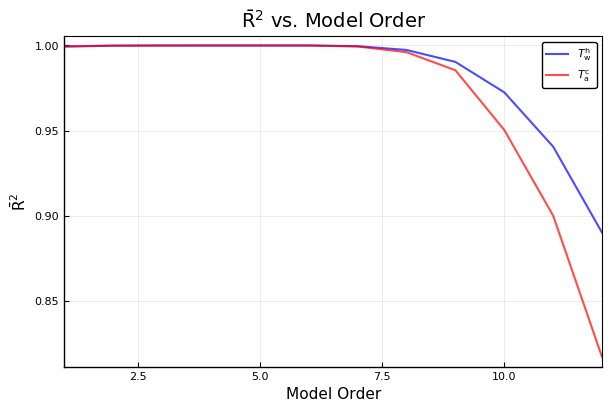

In [22]:
plot(results[1],results[6], label=L"$T_{\mathrm{w}}^{\mathrm{h}}$",lc=:blue,lw=LW2,ls=LS1,la=LA2)
plot!(results[1],results[7], label=L"$T_{\mathrm{a}}^{\mathrm{c}}$",lc=:red,lw=LW2,ls=LS1,la=LA2)
plot!(ylabel=L"$\bar{\mathrm{R}}^{2}$", xlabel="Model Order")
plot!(framestyle = :box,xlim =(1,length(results[1])),legend=:topright)
plot!(title=L"$\bar{\mathrm{R}}^{2}$ vs. Model Order")

figname = "R_bar_vs_Model_Order_case_1.svg"
savefig(Figpath*figname)

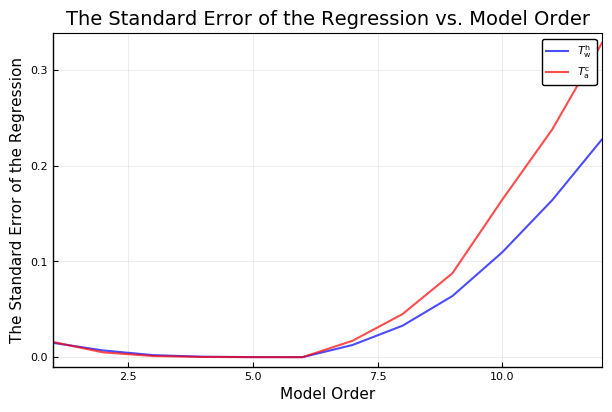

In [23]:
plot(results[1],results[3], label=L"$T_{\mathrm{w}}^{\mathrm{h}}$",lc=:blue,lw=LW2,ls=LS1,la=LA2)
plot!(results[1],results[4], label=L"$T_{\mathrm{a}}^{\mathrm{c}}$",lc=:red,lw=LW2,ls=LS1,la=LA2)
plot!(ylabel="The Standard Error of the Regression", xlabel="Model Order")
plot!(framestyle = :box,xlim =(1,length(results[1])),legend=:topright)
plot!(title="The Standard Error of the Regression vs. Model Order")

figname = "The_Standard_Error_of_the_Regression_vs_Model_Order_case_1.svg"
savefig(Figpath*figname)

Based on the previous plots, three model orders will be considered to demonstrate the goodness of fit:
1. Model 1: 1st order
2. Model 2: 6th order
3. Model 3: 12th order

#### Plotting

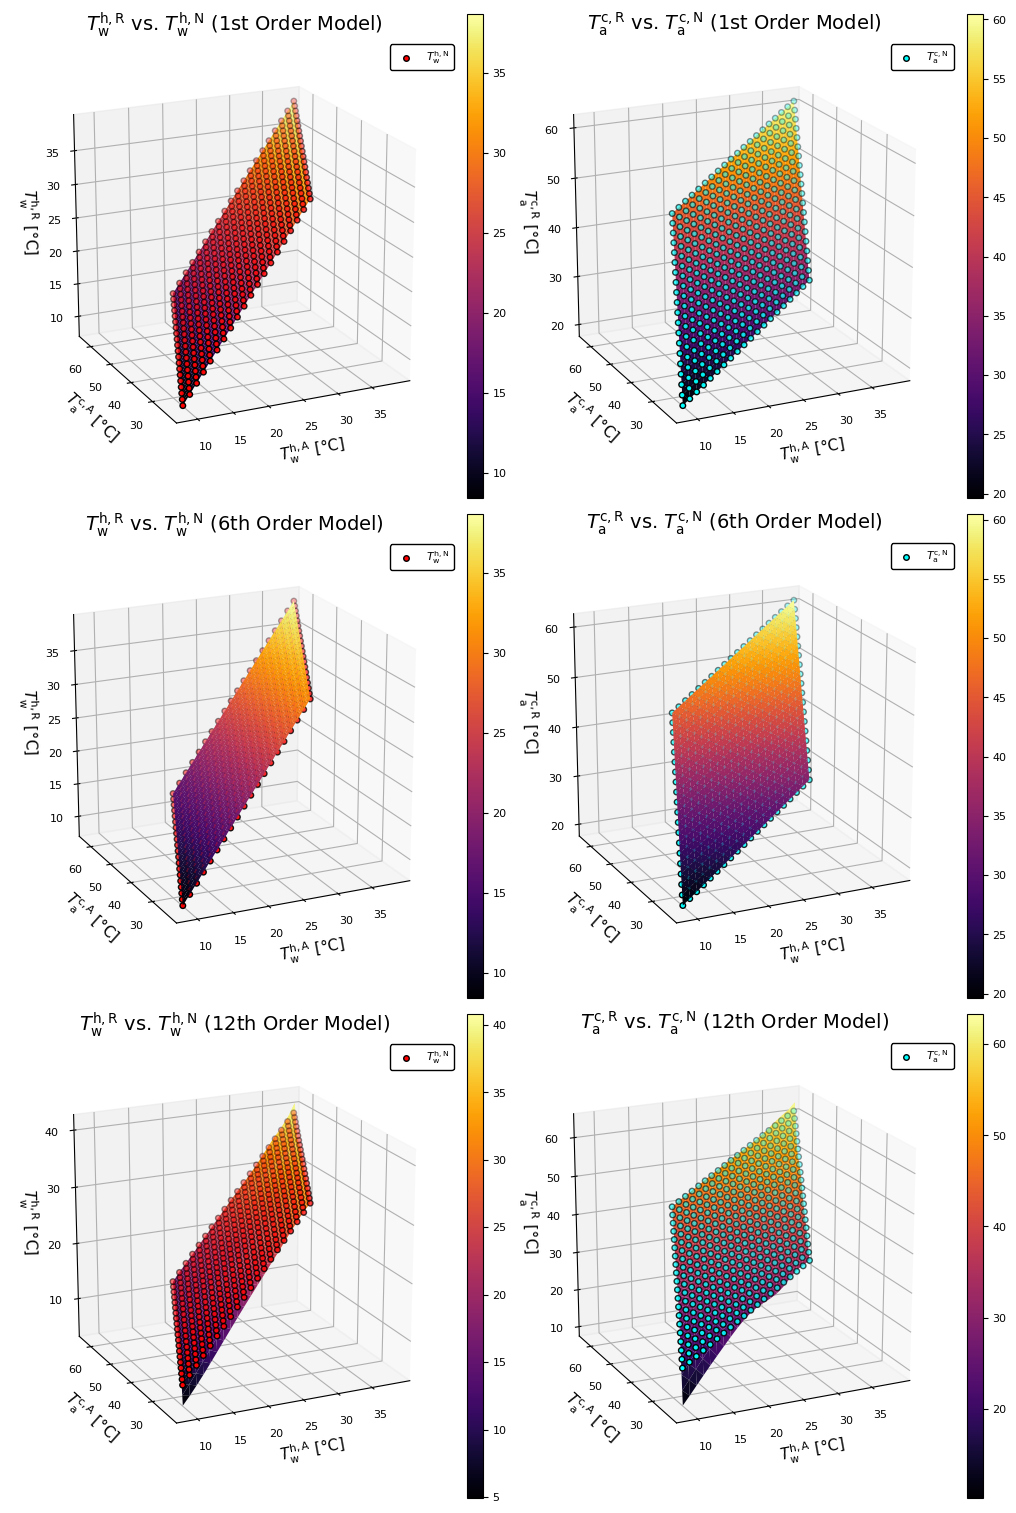

In [24]:
# 1st order
X = (phi_m.(mat2vec(TTAgrid_c1);n=1) |> x -> reduce(hcat,x))'  
Y = TTNgrid_c1';
β = X\Y
ŷ = X*β;
plot(TTAgrid_c1[1,:],TTAgrid_c1[2,:],ŷ[:,1],seriestype=:surface,xlabel=L"$T_{\mathrm{w}}^{\mathrm{h, A}}$ $[°\mathrm{C}]$", ylabel=L"$T_{\mathrm{a}}^{\mathrm{c, A}}$ $[°\mathrm{C}]$",zlabel=L"$T_{\mathrm{w}}^{\mathrm{h, R}}$ $[°\mathrm{C}]$")
fg1 = scatter!(TTAgrid_c1[1,:],TTAgrid_c1[2,:],Y[:,1],camera=(-25,20),label=L"$T_{\mathrm{w}}^{\mathrm{h, N}}$",title=L"$T_{\mathrm{w}}^{\mathrm{h, R}}$ vs. $T_{\mathrm{w}}^{\mathrm{h, N}}$ (1st Order Model)",color="red")
plot(TTAgrid_c1[1,:],TTAgrid_c1[2,:],ŷ[:,2],seriestype=:surface,xlabel=L"$T_{\mathrm{w}}^{\mathrm{h, A}}$ $[°\mathrm{C}]$", ylabel=L"$T_{\mathrm{a}}^{\mathrm{c, A}}$ $[°\mathrm{C}]$",zlabel=L"$T_{\mathrm{a}}^{\mathrm{c, R}}$ $[°\mathrm{C}]$")
fg2 = scatter!(TTAgrid_c1[1,:],TTAgrid_c1[2,:],Y[:,2],camera=(-25,20),label=L"$T_{\mathrm{a}}^{\mathrm{c, N}}$",title=L"$T_{\mathrm{a}}^{\mathrm{c, R}}$ vs. $T_{\mathrm{a}}^{\mathrm{c, N}}$ (1st Order Model)",color="#00FFFF")
#
# 6th order
#
X = (phi_m.(mat2vec(TTAgrid_c1);n=6) |> x -> reduce(hcat,x))'  
Y = TTNgrid_c1';
β = X\Y
ŷ = X*β;
plot(TTAgrid_c1[1,:],TTAgrid_c1[2,:],ŷ[:,1],seriestype=:surface,xlabel=L"$T_{\mathrm{w}}^{\mathrm{h, A}}$ $[°\mathrm{C}]$", ylabel=L"$T_{\mathrm{a}}^{\mathrm{c, A}}$ $[°\mathrm{C}]$",zlabel=L"$T_{\mathrm{w}}^{\mathrm{h, R}}$ $[°\mathrm{C}]$")
fg3 = scatter!(TTAgrid_c1[1,:],TTAgrid_c1[2,:],Y[:,1],camera=(-25,20),label=L"$T_{\mathrm{w}}^{\mathrm{h, N}}$",title=L"$T_{\mathrm{w}}^{\mathrm{h, R}}$ vs. $T_{\mathrm{w}}^{\mathrm{h, N}}$ (6th Order Model)",color="red")
plot(TTAgrid_c1[1,:],TTAgrid_c1[2,:],ŷ[:,2],seriestype=:surface,xlabel=L"$T_{\mathrm{w}}^{\mathrm{h, A}}$ $[°\mathrm{C}]$", ylabel=L"$T_{\mathrm{a}}^{\mathrm{c, A}}$ $[°\mathrm{C}]$",zlabel=L"$T_{\mathrm{a}}^{\mathrm{c, R}}$ $[°\mathrm{C}]$")
fg4 = scatter!(TTAgrid_c1[1,:],TTAgrid_c1[2,:],Y[:,2],camera=(-25,20),label=L"$T_{\mathrm{a}}^{\mathrm{c, N}}$",title=L"$T_{\mathrm{a}}^{\mathrm{c, R}}$ vs. $T_{\mathrm{a}}^{\mathrm{c, N}}$ (6th Order Model)",color="#00FFFF")
#
# 12th order
#
X = (phi_m.(mat2vec(TTAgrid_c1);n=12) |> x -> reduce(hcat,x))'  
Y = TTNgrid_c1';
β = X\Y
ŷ = X*β;
plot(TTAgrid_c1[1,:],TTAgrid_c1[2,:],ŷ[:,1],seriestype=:surface,xlabel=L"$T_{\mathrm{w}}^{\mathrm{h, A}}$ $[°\mathrm{C}]$", ylabel=L"$T_{\mathrm{a}}^{\mathrm{c, A}}$ $[°\mathrm{C}]$",zlabel=L"$T_{\mathrm{w}}^{\mathrm{h, R}}$ $[°\mathrm{C}]$")
fg5 = scatter!(TTAgrid_c1[1,:],TTAgrid_c1[2,:],Y[:,1],camera=(-25,20),label=L"$T_{\mathrm{w}}^{\mathrm{h, N}}$",title=L"$T_{\mathrm{w}}^{\mathrm{h, R}}$ vs. $T_{\mathrm{w}}^{\mathrm{h, N}}$ (12th Order Model)",color="red")
plot(TTAgrid_c1[1,:],TTAgrid_c1[2,:],ŷ[:,2],seriestype=:surface,xlabel=L"$T_{\mathrm{w}}^{\mathrm{h, A}}$ $[°\mathrm{C}]$", ylabel=L"$T_{\mathrm{a}}^{\mathrm{c, A}}$ $[°\mathrm{C}]$",zlabel=L"$T_{\mathrm{a}}^{\mathrm{c, R}}$ $[°\mathrm{C}]$")
fg6 = scatter!(TTAgrid_c1[1,:],TTAgrid_c1[2,:],Y[:,2],camera=(-25,20),label=L"$T_{\mathrm{a}}^{\mathrm{c, N}}$",title=L"$T_{\mathrm{a}}^{\mathrm{c, R}}$ vs. $T_{\mathrm{a}}^{\mathrm{c, N}}$ (12th Order Model)",color="#00FFFF")

plot(fg1,fg2,fg3,fg4,fg5,fg6,
    layout=grid(3,2),size = (1000, 1500),framestyle = :box,bottom_margin=10mm)
Figname = "Regression_of_1st_6th_12th_order_models_case_1.svg"
savefig(Figpath*Figname)

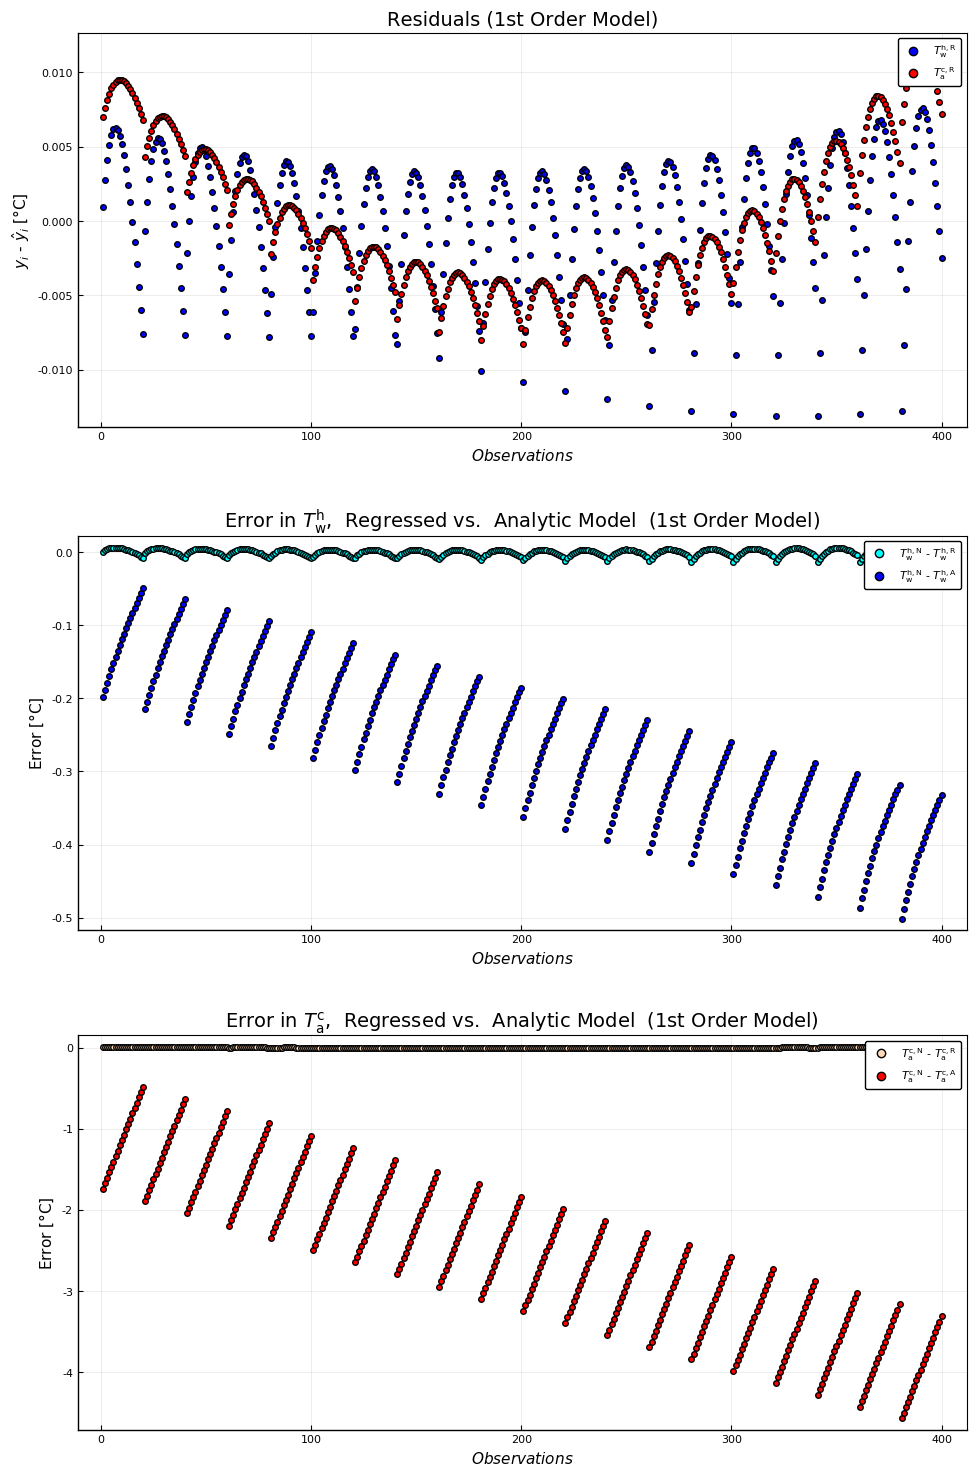

In [25]:
# 1st order
X = (phi_m.(mat2vec(TTAgrid_c1);n=1) |> x -> reduce(hcat,x))'  
Y = TTNgrid_c1';
β = X\Y
ŷ = X*β;

scatter((Y[:,1].-ŷ[:,1]),label=L"$T_{\mathrm{w}}^{\mathrm{h, R}}$",legend=:topright,color="blue")
scatter!((Y[:,2].-ŷ[:,2]),label=L"$T_{\mathrm{a}}^{\mathrm{c, R}}$",color="red")
fg1=plot!(title="Residuals (1st Order Model)",xlabel=L"Observations", ylabel=L"$y_{i}$ - $\hat{y}_{i}$ $[°\mathrm{C}]$")
scatter(Y[:,1].-ŷ[:,1], label=L"$T_{\mathrm{w}}^{\mathrm{h, N}}$ - $T_{\mathrm{w}}^{\mathrm{h, R}}$",legend=:topright,color="#00FFFF")
scatter!(Y[:,1].-TTAgrid_c1'[:,1], label=L"$T_{\mathrm{w}}^{\mathrm{h, N}}$ - $T_{\mathrm{w}}^{\mathrm{h, A}}$",color="blue")
fg2=plot!(title=L"Error in $T_{\mathrm{w}}^{\mathrm{h}}$,  Regressed vs.  Analytic Model  (1st Order Model)",xlabel=L"Observations",ylabel=L"Error $[°\mathrm{C}]$")
scatter(Y[:,2].-ŷ[:,2], label=L"$T_{\mathrm{a}}^{\mathrm{c, N}}$ - $T_{\mathrm{a}}^{\mathrm{c, R}}$",legend=:topright,color="#FFDAB9")
scatter!(Y[:,2].-TTAgrid_c1'[:,2], label=L"$T_{\mathrm{a}}^{\mathrm{c, N}}$ - $T_{\mathrm{a}}^{\mathrm{c, A}}$",color="red")
fg3=plot!(title=L"Error in $T_{\mathrm{a}}^{\mathrm{c}}$,  Regressed vs.  Analytic Model  (1st Order Model)",xlabel=L"Observations",ylabel=L"Error $[°\mathrm{C}]$")
plot(fg1,fg2,fg3,
    layout=grid(3,1),size = (1000, 1500),framestyle = :box,bottom_margin=10mm,right_margin=10mm)
Figname = "Regression_of_1st_order_models_case_1.svg"
savefig(Figpath*Figname)

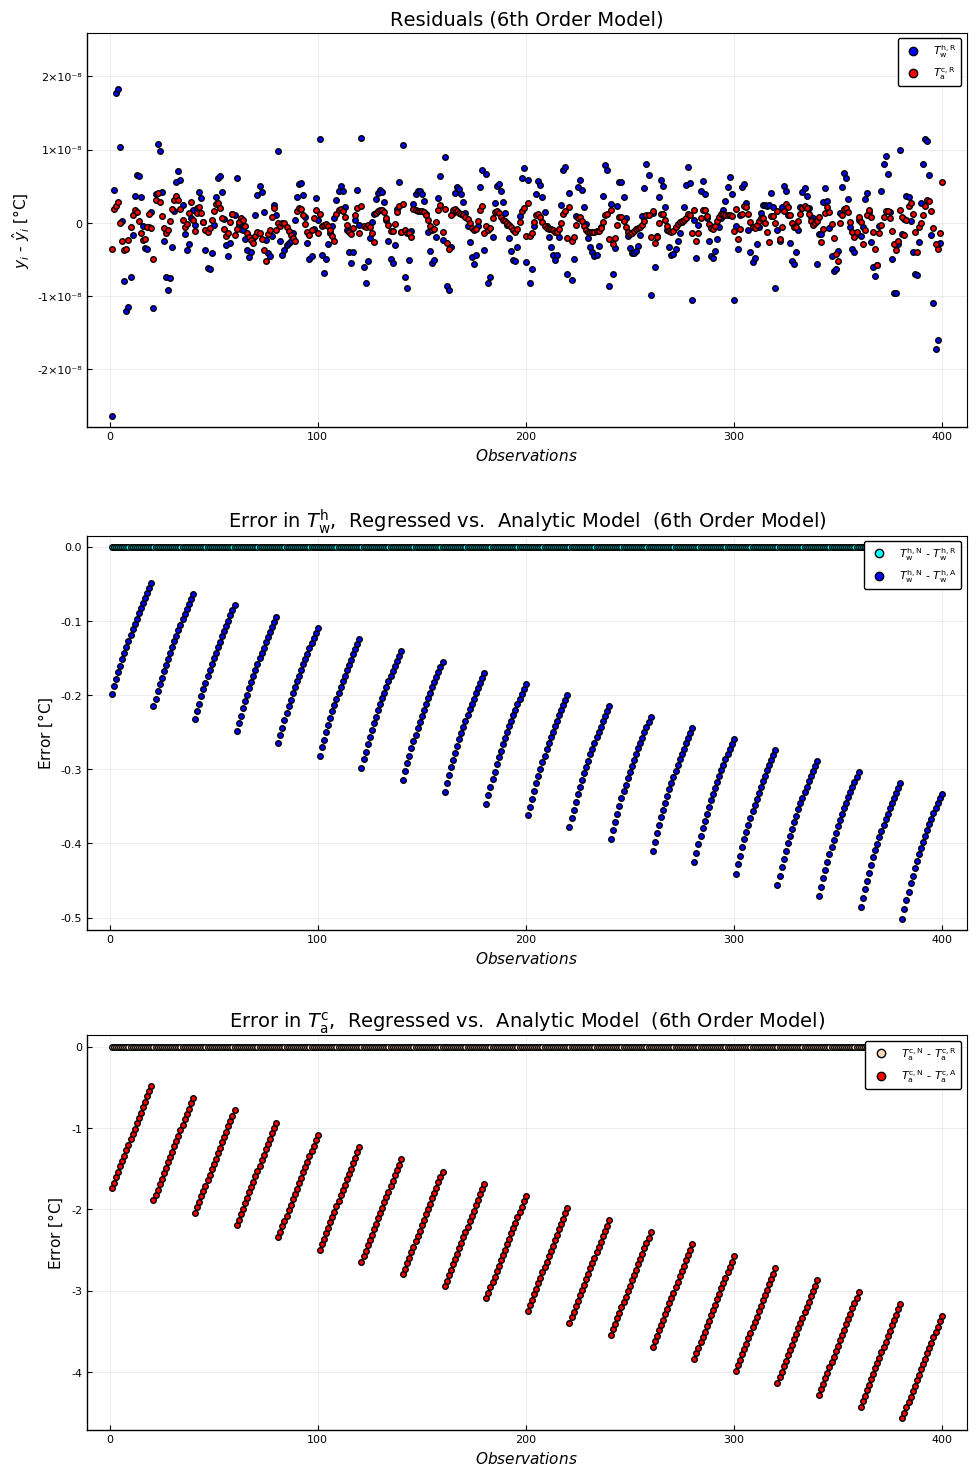

In [26]:
# 6th order
X = (phi_m.(mat2vec(TTAgrid_c1);n=6) |> x -> reduce(hcat,x))'  
Y = TTNgrid_c1';
β = X\Y
ŷ = X*β;

scatter((Y[:,1].-ŷ[:,1]),label=L"$T_{\mathrm{w}}^{\mathrm{h, R}}$",legend=:topright,color="blue")
scatter!((Y[:,2].-ŷ[:,2]),label=L"$T_{\mathrm{a}}^{\mathrm{c, R}}$",color="red")
fg1=plot!(title="Residuals (6th Order Model)",xlabel=L"Observations", ylabel=L"$y_{i}$ - $\hat{y}_{i}$ $[°\mathrm{C}]$")
scatter(Y[:,1].-ŷ[:,1], label=L"$T_{\mathrm{w}}^{\mathrm{h, N}}$ - $T_{\mathrm{w}}^{\mathrm{h, R}}$",legend=:topright,color="#00FFFF")
scatter!(Y[:,1].-TTAgrid_c1'[:,1], label=L"$T_{\mathrm{w}}^{\mathrm{h, N}}$ - $T_{\mathrm{w}}^{\mathrm{h, A}}$",color="blue")
fg2=plot!(title=L"Error in $T_{\mathrm{w}}^{\mathrm{h}}$,  Regressed vs.  Analytic Model  (6th Order Model)",xlabel=L"Observations",ylabel=L"Error $[°\mathrm{C}]$")
scatter(Y[:,2].-ŷ[:,2], label=L"$T_{\mathrm{a}}^{\mathrm{c, N}}$ - $T_{\mathrm{a}}^{\mathrm{c, R}}$",legend=:topright,color="#FFDAB9")
scatter!(Y[:,2].-TTAgrid_c1'[:,2], label=L"$T_{\mathrm{a}}^{\mathrm{c, N}}$ - $T_{\mathrm{a}}^{\mathrm{c, A}}$",color="red")
fg3=plot!(title=L"Error in $T_{\mathrm{a}}^{\mathrm{c}}$,  Regressed vs.  Analytic Model  (6th Order Model)",xlabel=L"Observations",ylabel=L"Error $[°\mathrm{C}]$")
plot(fg1,fg2,fg3,
    layout=grid(3,1),size = (1000, 1500),framestyle = :box,bottom_margin=10mm,right_margin=10mm)
Figname = "Regression_of_6th_order_models_case_1.svg"
savefig(Figpath*Figname)

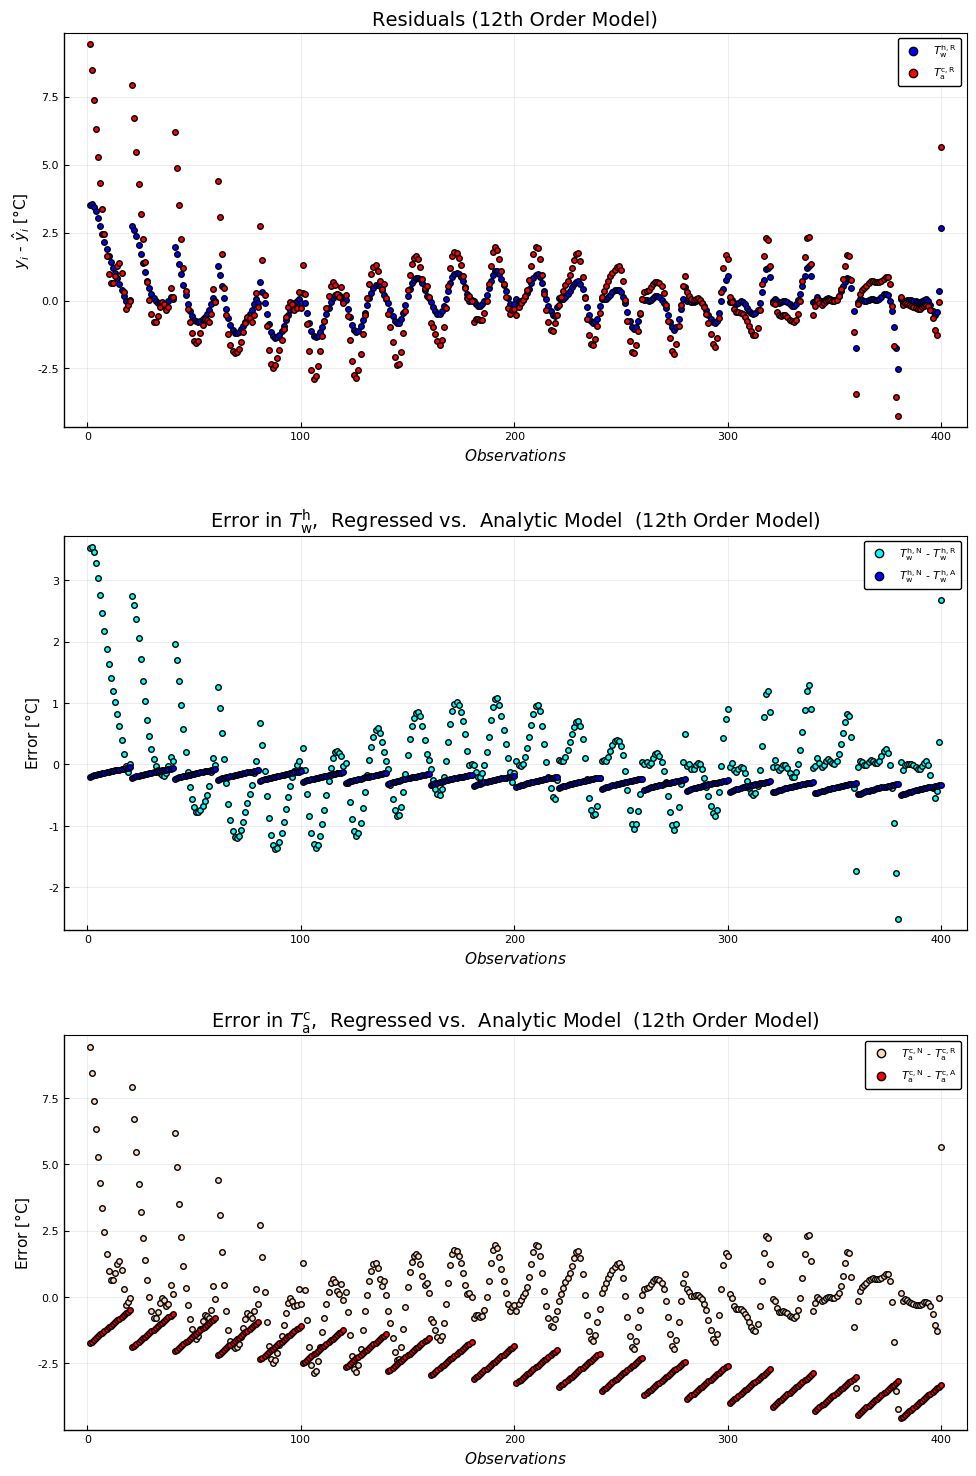

In [27]:
# 12th order
X = (phi_m.(mat2vec(TTAgrid_c1);n=12) |> x -> reduce(hcat,x))'  
Y = TTNgrid_c1';
β = X\Y
ŷ = X*β;

scatter((Y[:,1].-ŷ[:,1]),label=L"$T_{\mathrm{w}}^{\mathrm{h, R}}$",legend=:topright,color="blue")
scatter!((Y[:,2].-ŷ[:,2]),label=L"$T_{\mathrm{a}}^{\mathrm{c, R}}$",color="red")
fg1=plot!(title="Residuals (12th Order Model)",xlabel=L"Observations", ylabel=L"$y_{i}$ - $\hat{y}_{i}$ $[°\mathrm{C}]$")
scatter(Y[:,1].-ŷ[:,1], label=L"$T_{\mathrm{w}}^{\mathrm{h, N}}$ - $T_{\mathrm{w}}^{\mathrm{h, R}}$",legend=:topright,color="#00FFFF")
scatter!(Y[:,1].-TTAgrid_c1'[:,1], label=L"$T_{\mathrm{w}}^{\mathrm{h, N}}$ - $T_{\mathrm{w}}^{\mathrm{h, A}}$",color="blue")
fg2=plot!(title=L"Error in $T_{\mathrm{w}}^{\mathrm{h}}$,  Regressed vs.  Analytic Model  (12th Order Model)",xlabel=L"Observations",ylabel=L"Error $[°\mathrm{C}]$")
scatter(Y[:,2].-ŷ[:,2], label=L"$T_{\mathrm{a}}^{\mathrm{c, N}}$ - $T_{\mathrm{a}}^{\mathrm{c, R}}$",legend=:topright,color="#FFDAB9")
scatter!(Y[:,2].-TTAgrid_c1'[:,2], label=L"$T_{\mathrm{a}}^{\mathrm{c, N}}$ - $T_{\mathrm{a}}^{\mathrm{c, A}}$",color="red")
fg3=plot!(title=L"Error in $T_{\mathrm{a}}^{\mathrm{c}}$,  Regressed vs.  Analytic Model  (12th Order Model)",xlabel=L"Observations",ylabel=L"Error $[°\mathrm{C}]$")
plot(fg1,fg2,fg3,
    layout=grid(3,1),size = (1000, 1500),framestyle = :box,bottom_margin=10mm,right_margin=10mm)
Figname = "Regression_of_12th_order_models_case_1.svg"
savefig(Figpath*Figname)

#### Validation
##### Model 1: 1st order

In [28]:
multiple_Holdout(TTAgrid_c1,TTNgrid_c1,1,ngrid,0.50,1000)

The average standard error of the regression for Y1: 0.01797396
The average standard error of the regression for Y2: 0.0190537

The average adjusted coefficient of determination for Y1: 0.99938061
The average adjusted coefficient of determination for Y2: 0.99944294

The average RMSE for Y1: 0.00450191
The average RMSE for Y2: 0.00505826


##### Model 2: 6th order

In [29]:
multiple_Holdout(TTAgrid_c1,TTNgrid_c1,6,ngrid,0.50,1000)

The average standard error of the regression for Y1: 8.062e-5
The average standard error of the regression for Y2: 9.369e-5

The average adjusted coefficient of determination for Y1: 0.99999987
The average adjusted coefficient of determination for Y2: 0.99999979

The average RMSE for Y1: 9.7e-7
The average RMSE for Y2: 1.96e-6


##### Model 3: 12th order

In [30]:
multiple_Holdout(TTAgrid_c1,TTNgrid_c1,12,ngrid,0.50,1000)

The average standard error of the regression for Y1: 0.41295796
The average standard error of the regression for Y2: 0.59963816

The average adjusted coefficient of determination for Y1: 0.80846771
The average adjusted coefficient of determination for Y2: 0.67603817

The average RMSE for Y1: 1.39820202
The average RMSE for Y2: 2.9637627


### Case II: constant temperatures (`Twc` & `Tah`), and variable mass flow rates (`mdw` & `mda`). (A) Mass flow rates are generated in a high range, including the values used in case 1.
#### Generating the dataset

In [31]:
# Experimental ranges
n_mdw = 20
n_mda = 20
ngrid = n_mdw*n_mda
#
r_mdw = range(40.,100.,length=n_mdw)
r_mda = range(40.,100.,length=n_mda)
#
md_grid = [[mdw,mda] for mdw in r_mdw, mda in r_mda]
TTAgrid_c2 = Matrix{Float64}(undef,2,ngrid) # dimension 2xngrid
TTNgrid_c2 = Matrix{Float64}(undef,2,ngrid);

In [32]:
# Solving model for all inputs
@showprogress for i in 1:ngrid
    sleep(0.1)
    mdw, mda = md_grid[i]
    u_hex = [Twc  Tah  mdw  mda]        
    sol_analytic = map(dx -> hex_a(u_hex, par_hex_a, dx), xspan_a)
    TTAgrid_c2[:,i] .= [sol_analytic[end][1],sol_analytic[1][end]] #### Note: Sol[row][column] #### Each loop fill 1 column.Notice ".=" 
    sol_numeric = hex_n(u_hex, par_hex_n, xspan_n)
    TTNgrid_c2[:,i] .= [sol_numeric[end][1],sol_numeric[1][end]]
end

Progress: 100%|█████████████████████████████████████████| Time: 0:01:10


#### Find the best fit degree/order of the model using the standard error of the regression and $\bar{\mathrm{R}}^{2}$

In [33]:
results = goodness_of_fit(TTAgrid_c2,TTNgrid_c2,19) |> mat2vec;

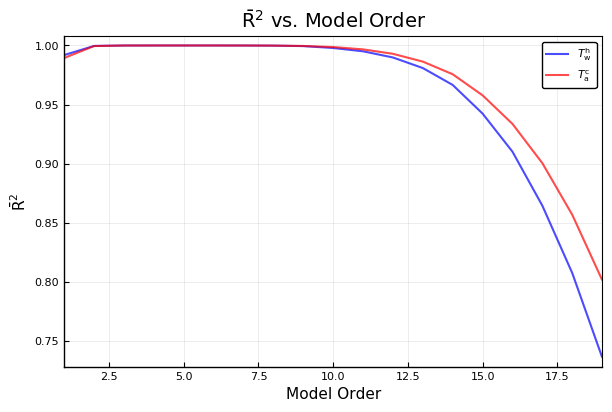

In [34]:
plot(results[1],results[6], label=L"$T_{\mathrm{w}}^{\mathrm{h}}$",lc=:blue,lw=LW2,ls=LS1,la=LA2)
plot!(results[1],results[7], label=L"$T_{\mathrm{a}}^{\mathrm{c}}$",lc=:red,lw=LW2,ls=LS1,la=LA2)
plot!(ylabel=L"$\bar{\mathrm{R}}^{2}$", xlabel="Model Order")
plot!(framestyle = :box,xlim =(1,length(results[1])),legend=:topright)
plot!(title=L"$\bar{\mathrm{R}}^{2}$ vs. Model Order")

figname = "R_bar_vs_Model_Order_case_2a.svg"
savefig(Figpath*figname)

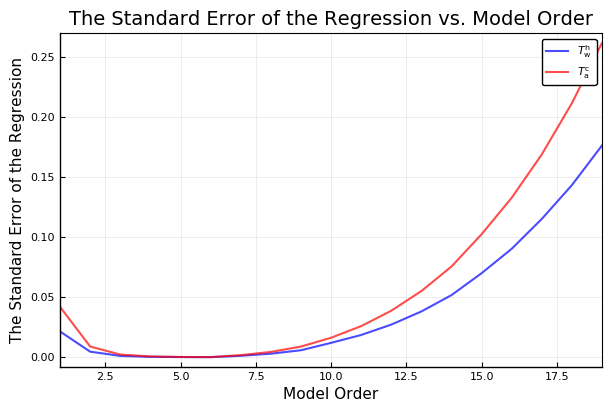

In [35]:
plot(results[1],results[3], label=L"$T_{\mathrm{w}}^{\mathrm{h}}$",lc=:blue,lw=LW2,ls=LS1,la=LA2)
plot!(results[1],results[4], label=L"$T_{\mathrm{a}}^{\mathrm{c}}$",lc=:red,lw=LW2,ls=LS1,la=LA2)
plot!(ylabel="The Standard Error of the Regression", xlabel="Model Order")
plot!(framestyle = :box,xlim =(1,length(results[1])),legend=:topright)
plot!(title="The Standard Error of the Regression vs. Model Order")

figname = "The_Standard_Error_of_the_Regression_vs_Model_Order_case_2a.svg"
savefig(Figpath*figname)

Based on the previous plots, three model orders will be considered to demonstrate the goodness of fit:
1. Model 1: 1st order
2. Model 2: 6th order
3. Model 3: 18th order

#### Plotting

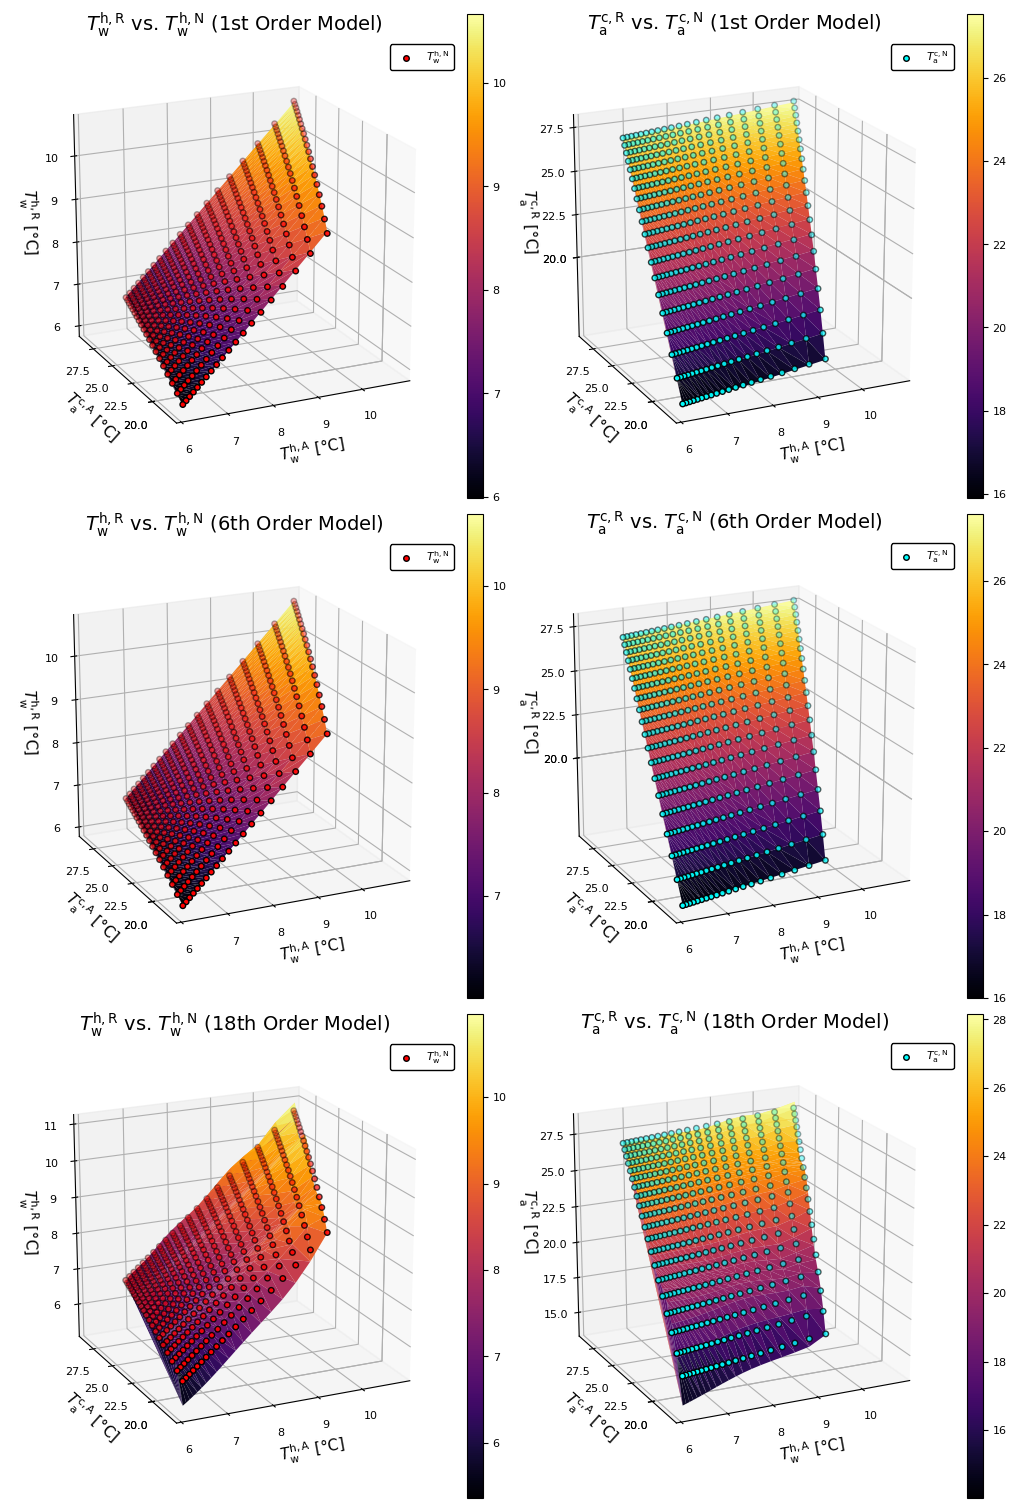

In [36]:
# 1st order
X = (phi_m.(mat2vec(TTAgrid_c2);n=1) |> x -> reduce(hcat,x))'  
Y = TTNgrid_c2';
β = X\Y
ŷ = X*β;
plot(TTAgrid_c2[1,:],TTAgrid_c2[2,:],ŷ[:,1],seriestype=:surface,xlabel=L"$T_{\mathrm{w}}^{\mathrm{h, A}}$ $[°\mathrm{C}]$", ylabel=L"$T_{\mathrm{a}}^{\mathrm{c, A}}$ $[°\mathrm{C}]$",zlabel=L"$T_{\mathrm{w}}^{\mathrm{h, R}}$ $[°\mathrm{C}]$")
fg1 = scatter!(TTAgrid_c2[1,:],TTAgrid_c2[2,:],Y[:,1],camera=(-25,20),label=L"$T_{\mathrm{w}}^{\mathrm{h, N}}$",title=L"$T_{\mathrm{w}}^{\mathrm{h, R}}$ vs. $T_{\mathrm{w}}^{\mathrm{h, N}}$ (1st Order Model)",color="red")
plot(TTAgrid_c2[1,:],TTAgrid_c2[2,:],ŷ[:,2],seriestype=:surface,xlabel=L"$T_{\mathrm{w}}^{\mathrm{h, A}}$ $[°\mathrm{C}]$", ylabel=L"$T_{\mathrm{a}}^{\mathrm{c, A}}$ $[°\mathrm{C}]$",zlabel=L"$T_{\mathrm{a}}^{\mathrm{c, R}}$ $[°\mathrm{C}]$")
fg2 = scatter!(TTAgrid_c2[1,:],TTAgrid_c2[2,:],Y[:,2],camera=(-25,20),label=L"$T_{\mathrm{a}}^{\mathrm{c, N}}$",title=L"$T_{\mathrm{a}}^{\mathrm{c, R}}$ vs. $T_{\mathrm{a}}^{\mathrm{c, N}}$ (1st Order Model)",color="#00FFFF")
#
# 6th order
#
X = (phi_m.(mat2vec(TTAgrid_c2);n=6) |> x -> reduce(hcat,x))'  
Y = TTNgrid_c2';
β = X\Y
ŷ = X*β;
plot(TTAgrid_c2[1,:],TTAgrid_c2[2,:],ŷ[:,1],seriestype=:surface,xlabel=L"$T_{\mathrm{w}}^{\mathrm{h, A}}$ $[°\mathrm{C}]$", ylabel=L"$T_{\mathrm{a}}^{\mathrm{c, A}}$ $[°\mathrm{C}]$",zlabel=L"$T_{\mathrm{w}}^{\mathrm{h, R}}$ $[°\mathrm{C}]$")
fg3 = scatter!(TTAgrid_c2[1,:],TTAgrid_c2[2,:],Y[:,1],camera=(-25,20),label=L"$T_{\mathrm{w}}^{\mathrm{h, N}}$",title=L"$T_{\mathrm{w}}^{\mathrm{h, R}}$ vs. $T_{\mathrm{w}}^{\mathrm{h, N}}$ (6th Order Model)",color="red")
plot(TTAgrid_c2[1,:],TTAgrid_c2[2,:],ŷ[:,2],seriestype=:surface,xlabel=L"$T_{\mathrm{w}}^{\mathrm{h, A}}$ $[°\mathrm{C}]$", ylabel=L"$T_{\mathrm{a}}^{\mathrm{c, A}}$ $[°\mathrm{C}]$",zlabel=L"$T_{\mathrm{a}}^{\mathrm{c, R}}$ $[°\mathrm{C}]$")
fg4 = scatter!(TTAgrid_c2[1,:],TTAgrid_c2[2,:],Y[:,2],camera=(-25,20),label=L"$T_{\mathrm{a}}^{\mathrm{c, N}}$",title=L"$T_{\mathrm{a}}^{\mathrm{c, R}}$ vs. $T_{\mathrm{a}}^{\mathrm{c, N}}$ (6th Order Model)",color="#00FFFF")
#
# 15th order
#
X = (phi_m.(mat2vec(TTAgrid_c2);n=18) |> x -> reduce(hcat,x))'  
Y = TTNgrid_c2';
β = X\Y
ŷ = X*β;
plot(TTAgrid_c2[1,:],TTAgrid_c2[2,:],ŷ[:,1],seriestype=:surface,xlabel=L"$T_{\mathrm{w}}^{\mathrm{h, A}}$ $[°\mathrm{C}]$", ylabel=L"$T_{\mathrm{a}}^{\mathrm{c, A}}$ $[°\mathrm{C}]$",zlabel=L"$T_{\mathrm{w}}^{\mathrm{h, R}}$ $[°\mathrm{C}]$")
fg5 = scatter!(TTAgrid_c2[1,:],TTAgrid_c2[2,:],Y[:,1],camera=(-25,20),label=L"$T_{\mathrm{w}}^{\mathrm{h, N}}$",title=L"$T_{\mathrm{w}}^{\mathrm{h, R}}$ vs. $T_{\mathrm{w}}^{\mathrm{h, N}}$ (18th Order Model)",color="red")
plot(TTAgrid_c2[1,:],TTAgrid_c2[2,:],ŷ[:,2],seriestype=:surface,xlabel=L"$T_{\mathrm{w}}^{\mathrm{h, A}}$ $[°\mathrm{C}]$", ylabel=L"$T_{\mathrm{a}}^{\mathrm{c, A}}$ $[°\mathrm{C}]$",zlabel=L"$T_{\mathrm{a}}^{\mathrm{c, R}}$ $[°\mathrm{C}]$")
fg6 = scatter!(TTAgrid_c2[1,:],TTAgrid_c2[2,:],Y[:,2],camera=(-25,20),label=L"$T_{\mathrm{a}}^{\mathrm{c, N}}$",title=L"$T_{\mathrm{a}}^{\mathrm{c, R}}$ vs. $T_{\mathrm{a}}^{\mathrm{c, N}}$ (18th Order Model)",color="#00FFFF")

plot(fg1,fg2,fg3,fg4,fg5,fg6,
    layout=grid(3,2),size = (1000, 1500),framestyle = :box,bottom_margin=10mm)
Figname = "Regression_of_1st_6th_18th_order_models_case_2a.svg"
savefig(Figpath*Figname)

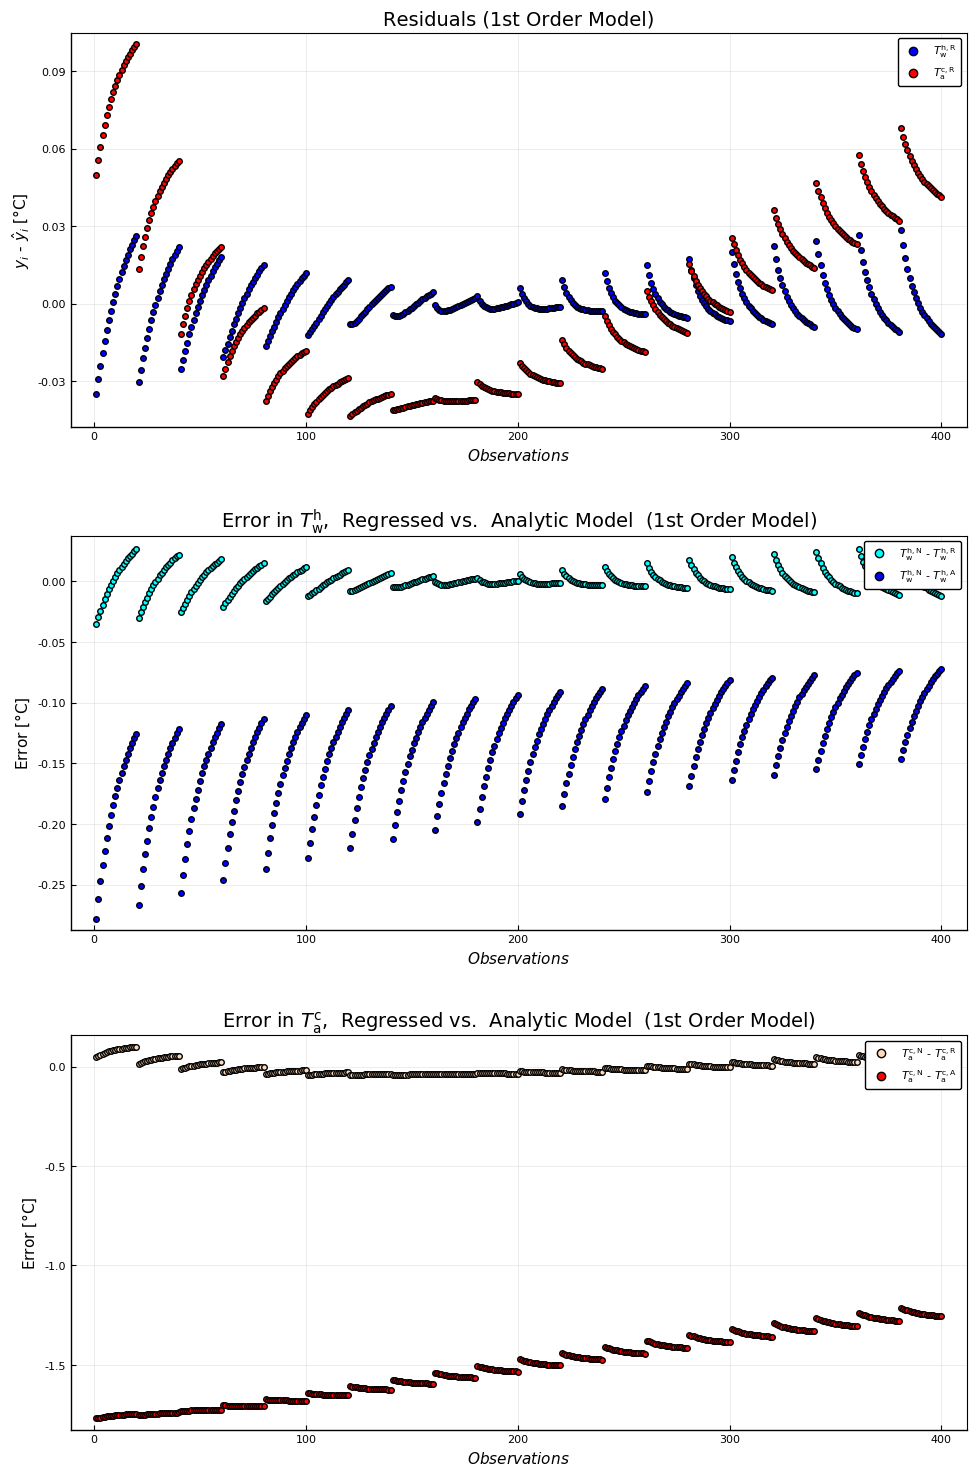

In [37]:
# 1st order
X = (phi_m.(mat2vec(TTAgrid_c2);n=1) |> x -> reduce(hcat,x))'  
Y = TTNgrid_c2';
β = X\Y
ŷ = X*β;

scatter((Y[:,1].-ŷ[:,1]),label=L"$T_{\mathrm{w}}^{\mathrm{h, R}}$",legend=:topright,color="blue")
scatter!((Y[:,2].-ŷ[:,2]),label=L"$T_{\mathrm{a}}^{\mathrm{c, R}}$",color="red")
fg1=plot!(title="Residuals (1st Order Model)",xlabel=L"Observations", ylabel=L"$y_{i}$ - $\hat{y}_{i}$ $[°\mathrm{C}]$")
scatter(Y[:,1].-ŷ[:,1], label=L"$T_{\mathrm{w}}^{\mathrm{h, N}}$ - $T_{\mathrm{w}}^{\mathrm{h, R}}$",legend=:topright,color="#00FFFF")
scatter!(Y[:,1].-TTAgrid_c2'[:,1], label=L"$T_{\mathrm{w}}^{\mathrm{h, N}}$ - $T_{\mathrm{w}}^{\mathrm{h, A}}$",color="blue")
fg2=plot!(title=L"Error in $T_{\mathrm{w}}^{\mathrm{h}}$,  Regressed vs.  Analytic Model  (1st Order Model)",xlabel=L"Observations",ylabel=L"Error $[°\mathrm{C}]$")
scatter(Y[:,2].-ŷ[:,2], label=L"$T_{\mathrm{a}}^{\mathrm{c, N}}$ - $T_{\mathrm{a}}^{\mathrm{c, R}}$",legend=:topright,color="#FFDAB9")
scatter!(Y[:,2].-TTAgrid_c2'[:,2], label=L"$T_{\mathrm{a}}^{\mathrm{c, N}}$ - $T_{\mathrm{a}}^{\mathrm{c, A}}$",color="red")
fg3=plot!(title=L"Error in $T_{\mathrm{a}}^{\mathrm{c}}$,  Regressed vs.  Analytic Model  (1st Order Model)",xlabel=L"Observations",ylabel=L"Error $[°\mathrm{C}]$")
plot(fg1,fg2,fg3,
    layout=grid(3,1),size = (1000, 1500),framestyle = :box,bottom_margin=10mm,right_margin=10mm)
Figname = "Regression_of_1st_order_models_case_2a.svg"
savefig(Figpath*Figname)

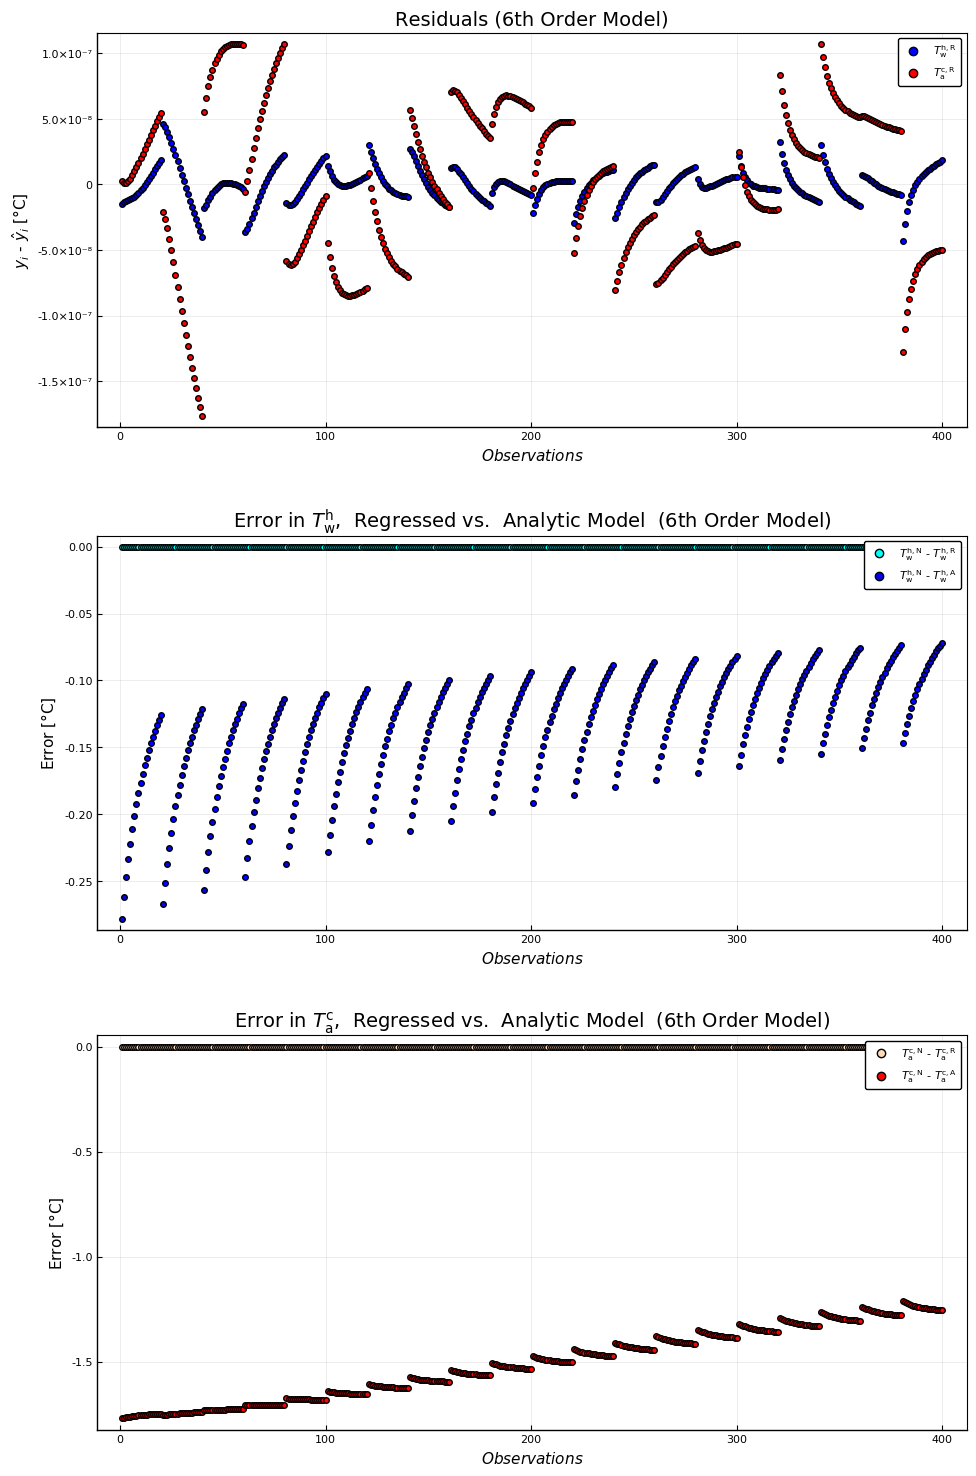

In [38]:
# 6th order
X = (phi_m.(mat2vec(TTAgrid_c2);n=6) |> x -> reduce(hcat,x))'  
Y = TTNgrid_c2';
β = X\Y
ŷ = X*β;

scatter((Y[:,1].-ŷ[:,1]),label=L"$T_{\mathrm{w}}^{\mathrm{h, R}}$",legend=:topright,color="blue")
scatter!((Y[:,2].-ŷ[:,2]),label=L"$T_{\mathrm{a}}^{\mathrm{c, R}}$",color="red")
fg1=plot!(title="Residuals (6th Order Model)",xlabel=L"Observations", ylabel=L"$y_{i}$ - $\hat{y}_{i}$ $[°\mathrm{C}]$")
scatter(Y[:,1].-ŷ[:,1], label=L"$T_{\mathrm{w}}^{\mathrm{h, N}}$ - $T_{\mathrm{w}}^{\mathrm{h, R}}$",legend=:topright,color="#00FFFF")
scatter!(Y[:,1].-TTAgrid_c2'[:,1], label=L"$T_{\mathrm{w}}^{\mathrm{h, N}}$ - $T_{\mathrm{w}}^{\mathrm{h, A}}$",color="blue")
fg2=plot!(title=L"Error in $T_{\mathrm{w}}^{\mathrm{h}}$,  Regressed vs.  Analytic Model  (6th Order Model)",xlabel=L"Observations",ylabel=L"Error $[°\mathrm{C}]$")
scatter(Y[:,2].-ŷ[:,2], label=L"$T_{\mathrm{a}}^{\mathrm{c, N}}$ - $T_{\mathrm{a}}^{\mathrm{c, R}}$",legend=:topright,color="#FFDAB9")
scatter!(Y[:,2].-TTAgrid_c2'[:,2], label=L"$T_{\mathrm{a}}^{\mathrm{c, N}}$ - $T_{\mathrm{a}}^{\mathrm{c, A}}$",color="red")
fg3=plot!(title=L"Error in $T_{\mathrm{a}}^{\mathrm{c}}$,  Regressed vs.  Analytic Model  (6th Order Model)",xlabel=L"Observations",ylabel=L"Error $[°\mathrm{C}]$")
plot(fg1,fg2,fg3,
    layout=grid(3,1),size = (1000, 1500),framestyle = :box,bottom_margin=10mm,right_margin=10mm)
Figname = "Regression_of_6th_order_models_case_2a.svg"
savefig(Figpath*Figname)

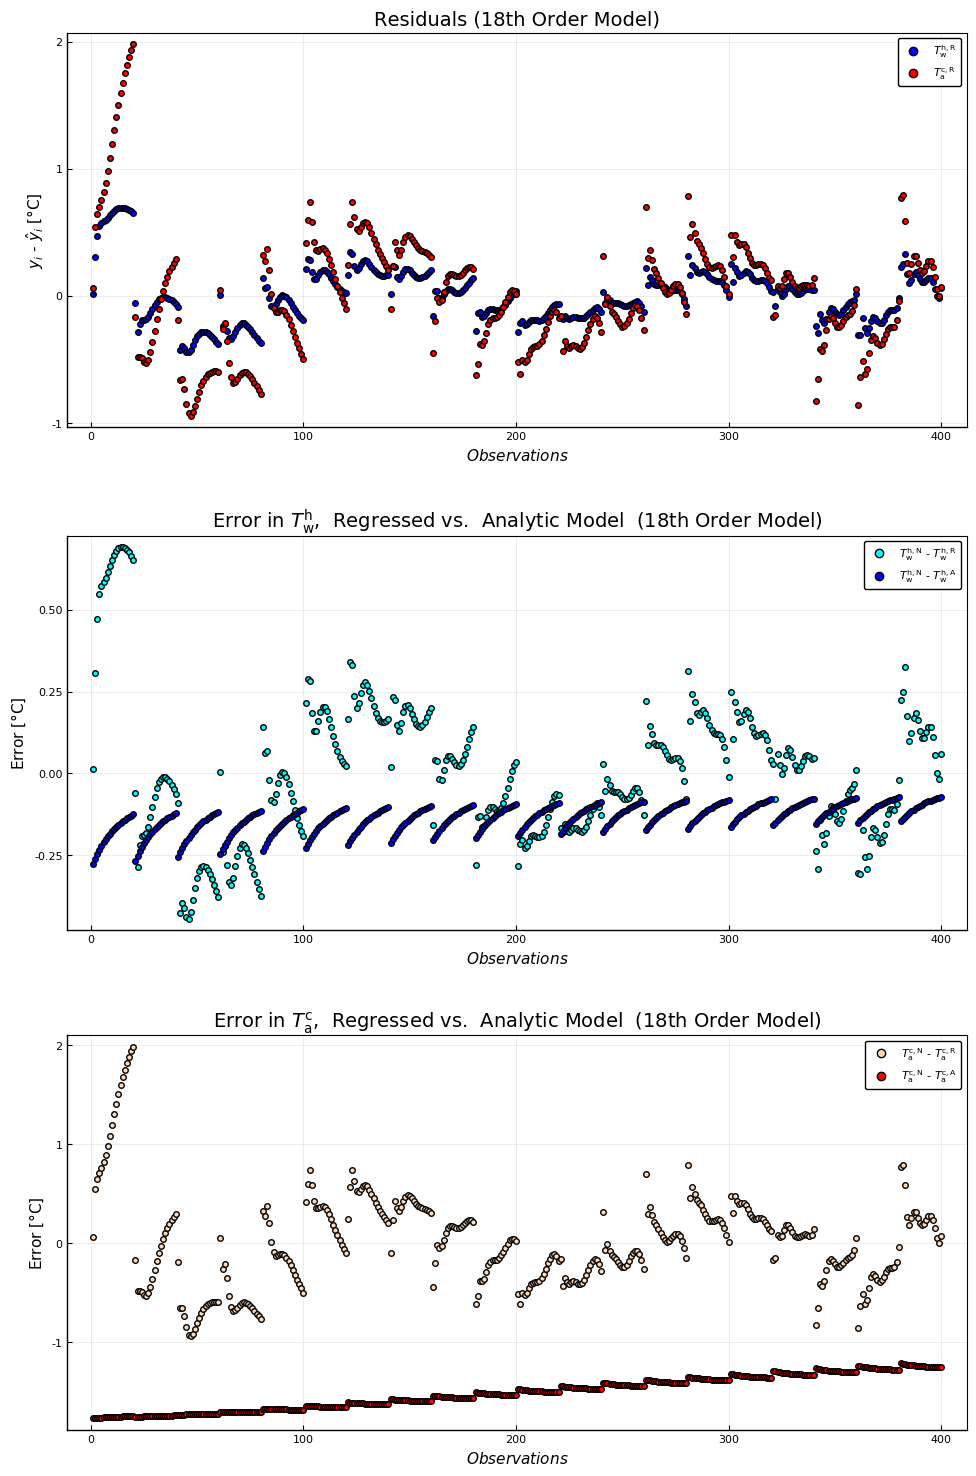

In [39]:
# 18th order
X = (phi_m.(mat2vec(TTAgrid_c2);n=18) |> x -> reduce(hcat,x))'  
Y = TTNgrid_c2';
β = X\Y
ŷ = X*β;

scatter((Y[:,1].-ŷ[:,1]),label=L"$T_{\mathrm{w}}^{\mathrm{h, R}}$",legend=:topright,color="blue")
scatter!((Y[:,2].-ŷ[:,2]),label=L"$T_{\mathrm{a}}^{\mathrm{c, R}}$",color="red")
fg1=plot!(title="Residuals (18th Order Model)",xlabel=L"Observations", ylabel=L"$y_{i}$ - $\hat{y}_{i}$ $[°\mathrm{C}]$")
scatter(Y[:,1].-ŷ[:,1], label=L"$T_{\mathrm{w}}^{\mathrm{h, N}}$ - $T_{\mathrm{w}}^{\mathrm{h, R}}$",legend=:topright,color="#00FFFF")
scatter!(Y[:,1].-TTAgrid_c2'[:,1], label=L"$T_{\mathrm{w}}^{\mathrm{h, N}}$ - $T_{\mathrm{w}}^{\mathrm{h, A}}$",color="blue")
fg2=plot!(title=L"Error in $T_{\mathrm{w}}^{\mathrm{h}}$,  Regressed vs.  Analytic Model  (18th Order Model)",xlabel=L"Observations",ylabel=L"Error $[°\mathrm{C}]$")
scatter(Y[:,2].-ŷ[:,2], label=L"$T_{\mathrm{a}}^{\mathrm{c, N}}$ - $T_{\mathrm{a}}^{\mathrm{c, R}}$",legend=:topright,color="#FFDAB9")
scatter!(Y[:,2].-TTAgrid_c2'[:,2], label=L"$T_{\mathrm{a}}^{\mathrm{c, N}}$ - $T_{\mathrm{a}}^{\mathrm{c, A}}$",color="red")
fg3=plot!(title=L"Error in $T_{\mathrm{a}}^{\mathrm{c}}$,  Regressed vs.  Analytic Model  (18th Order Model)",xlabel=L"Observations",ylabel=L"Error $[°\mathrm{C}]$")
plot(fg1,fg2,fg3,
    layout=grid(3,1),size = (1000, 1500),framestyle = :box,bottom_margin=10mm,right_margin=10mm)
Figname = "Regression_of_18th_order_models_case_2a.svg"
savefig(Figpath*Figname)

#### Validation
##### Model 1: 1st order

In [40]:
multiple_Holdout(TTAgrid_c2,TTNgrid_c2,1,ngrid,0.50,1000)

The average standard error of the regression for Y1: 0.0257428
The average standard error of the regression for Y2: 0.0503602

The average adjusted coefficient of determination for Y1: 0.99172604
The average adjusted coefficient of determination for Y2: 0.98918441

The average RMSE for Y1: 0.00923701
The average RMSE for Y2: 0.03534026


##### Model 2: 6th order

In [41]:
multiple_Holdout(TTAgrid_c2,TTNgrid_c2,6,ngrid,0.50,1000)

The average standard error of the regression for Y1: 4.705e-5
The average standard error of the regression for Y2: 8.981e-5

The average adjusted coefficient of determination for Y1: 0.99999994
The average adjusted coefficient of determination for Y2: 0.99999994

The average RMSE for Y1: 7.0e-8
The average RMSE for Y2: 1.9e-7


##### Model 3: 18th order

In [42]:
multiple_Holdout(TTAgrid_c2,TTNgrid_c2,18,ngrid,0.50,1000)

The average standard error of the regression for Y1: 0.64079578
The average standard error of the regression for Y2: 0.94432409

The average adjusted coefficient of determination for Y1: 0.73520221
The average adjusted coefficient of determination for Y2: 0.80353184

The average RMSE for Y1: 0.296523
The average RMSE for Y2: 0.64326974


### Case II: (B) Mass flow rates are generated to a lower range than the previous case. Here, the aim is to evaluate the impact of mass flow rate on the goodness-of-fit.
#### Generating the dataset

In [43]:
# Experimental ranges
n_mdw = 20
n_mda = 20
ngrid = n_mdw*n_mda
#
r_mdw = range(20.,100.,length=n_mdw)
r_mda = range(20.,100.,length=n_mda)
#
md_grid = [[mdw,mda] for mdw in r_mdw, mda in r_mda]
TTAgrid_c2_b = Matrix{Float64}(undef,2,ngrid) # dimension 2xngrid
TTNgrid_c2_b = Matrix{Float64}(undef,2,ngrid);

In [44]:
# Solving model for all inputs
@showprogress for i in 1:ngrid
    sleep(0.1)
    mdw, mda = md_grid[i]
    u_hex = [Twc  Tah  mdw  mda]        
    sol_analytic = map(dx -> hex_a(u_hex, par_hex_a, dx), xspan_a)
    TTAgrid_c2_b[:,i] .= [sol_analytic[end][1],sol_analytic[1][end]] #### Note: Sol[row][column] #### Each loop fill 1 column.Notice ".=" 
    sol_numeric = hex_n(u_hex, par_hex_n, xspan_n)
    TTNgrid_c2_b[:,i] .= [sol_numeric[end][1],sol_numeric[1][end]]
end

Progress: 100%|█████████████████████████████████████████| Time: 0:01:11


#### Find the best fit degree/order of the model using the standard error of the regression and $\bar{\mathrm{R}}^{2}$

In [45]:
results = goodness_of_fit(TTAgrid_c2_b,TTNgrid_c2_b,19) |> mat2vec;

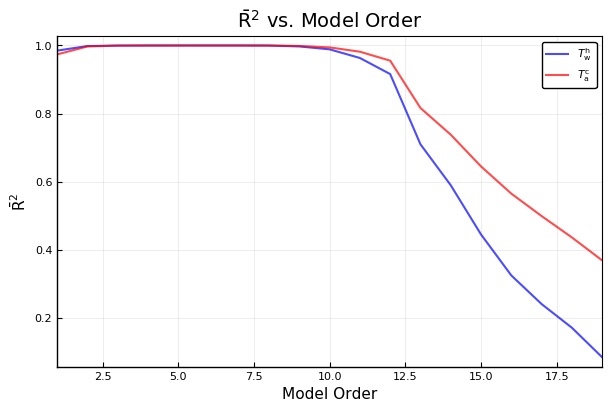

In [46]:
plot(results[1],results[6], label=L"$T_{\mathrm{w}}^{\mathrm{h}}$",lc=:blue,lw=LW2,ls=LS1,la=LA2)
plot!(results[1],results[7], label=L"$T_{\mathrm{a}}^{\mathrm{c}}$",lc=:red,lw=LW2,ls=LS1,la=LA2)
plot!(ylabel=L"$\bar{\mathrm{R}}^{2}$", xlabel="Model Order")
plot!(framestyle = :box,xlim =(1,length(results[1])),legend=:topright)
plot!(title=L"$\bar{\mathrm{R}}^{2}$ vs. Model Order")

figname = "R_bar_vs_Model_Order_case_2b.svg"
savefig(Figpath*figname)

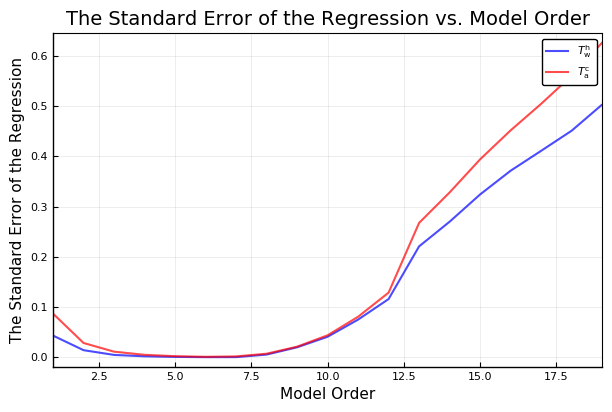

In [47]:
plot(results[1],results[3], label=L"$T_{\mathrm{w}}^{\mathrm{h}}$",lc=:blue,lw=LW2,ls=LS1,la=LA2)
plot!(results[1],results[4], label=L"$T_{\mathrm{a}}^{\mathrm{c}}$",lc=:red,lw=LW2,ls=LS1,la=LA2)
plot!(ylabel="The Standard Error of the Regression", xlabel="Model Order")
plot!(framestyle = :box,xlim =(1,length(results[1])),legend=:topright)
plot!(title="The Standard Error of the Regression vs. Model Order")

figname = "The_Standard_Error_of_the_Regression_vs_Model_Order_case_2b.svg"
savefig(Figpath*figname)

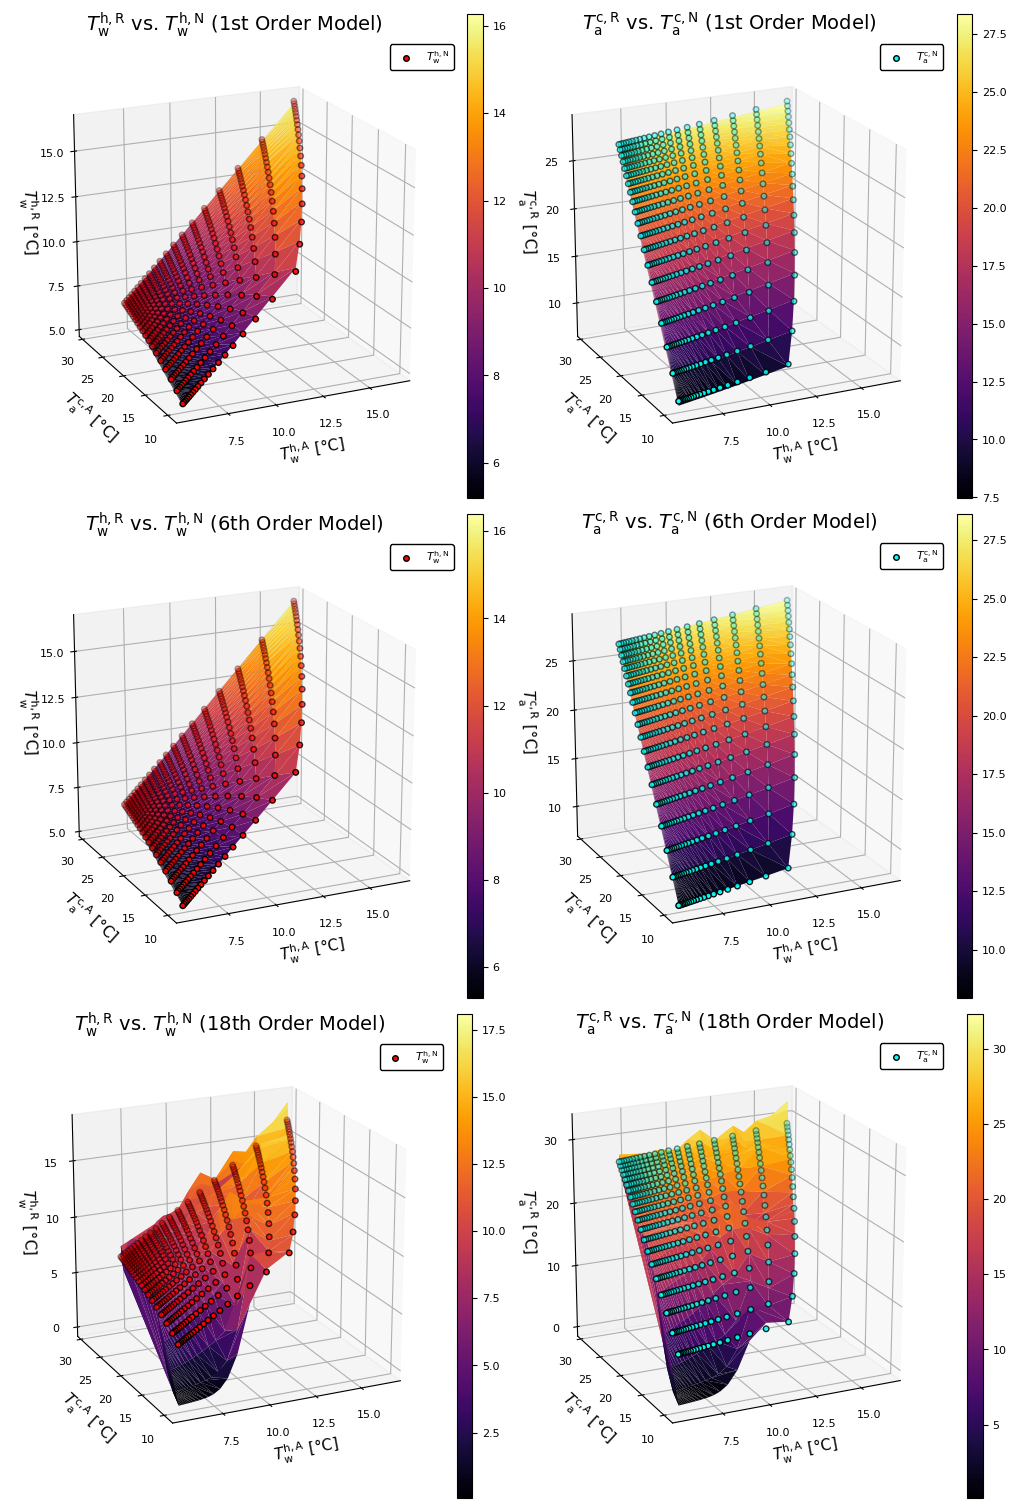

In [48]:
# 1st order
X = (phi_m.(mat2vec(TTAgrid_c2_b);n=1) |> x -> reduce(hcat,x))'  
Y = TTNgrid_c2_b';
β = X\Y
ŷ = X*β;
plot(TTAgrid_c2_b[1,:],TTAgrid_c2_b[2,:],ŷ[:,1],seriestype=:surface,xlabel=L"$T_{\mathrm{w}}^{\mathrm{h, A}}$ $[°\mathrm{C}]$", ylabel=L"$T_{\mathrm{a}}^{\mathrm{c, A}}$ $[°\mathrm{C}]$",zlabel=L"$T_{\mathrm{w}}^{\mathrm{h, R}}$ $[°\mathrm{C}]$")
fg1 = scatter!(TTAgrid_c2_b[1,:],TTAgrid_c2_b[2,:],Y[:,1],camera=(-25,20),label=L"$T_{\mathrm{w}}^{\mathrm{h, N}}$",title=L"$T_{\mathrm{w}}^{\mathrm{h, R}}$ vs. $T_{\mathrm{w}}^{\mathrm{h, N}}$ (1st Order Model)",color="red")
plot(TTAgrid_c2_b[1,:],TTAgrid_c2_b[2,:],ŷ[:,2],seriestype=:surface,xlabel=L"$T_{\mathrm{w}}^{\mathrm{h, A}}$ $[°\mathrm{C}]$", ylabel=L"$T_{\mathrm{a}}^{\mathrm{c, A}}$ $[°\mathrm{C}]$",zlabel=L"$T_{\mathrm{a}}^{\mathrm{c, R}}$ $[°\mathrm{C}]$")
fg2 = scatter!(TTAgrid_c2_b[1,:],TTAgrid_c2_b[2,:],Y[:,2],camera=(-25,20),label=L"$T_{\mathrm{a}}^{\mathrm{c, N}}$",title=L"$T_{\mathrm{a}}^{\mathrm{c, R}}$ vs. $T_{\mathrm{a}}^{\mathrm{c, N}}$ (1st Order Model)",color="#00FFFF")
#
# 6th order
#
X = (phi_m.(mat2vec(TTAgrid_c2_b);n=6) |> x -> reduce(hcat,x))'  
Y = TTNgrid_c2_b';
β = X\Y
ŷ = X*β;
plot(TTAgrid_c2_b[1,:],TTAgrid_c2_b[2,:],ŷ[:,1],seriestype=:surface,xlabel=L"$T_{\mathrm{w}}^{\mathrm{h, A}}$ $[°\mathrm{C}]$", ylabel=L"$T_{\mathrm{a}}^{\mathrm{c, A}}$ $[°\mathrm{C}]$",zlabel=L"$T_{\mathrm{w}}^{\mathrm{h, R}}$ $[°\mathrm{C}]$")
fg3 = scatter!(TTAgrid_c2_b[1,:],TTAgrid_c2_b[2,:],Y[:,1],camera=(-25,20),label=L"$T_{\mathrm{w}}^{\mathrm{h, N}}$",title=L"$T_{\mathrm{w}}^{\mathrm{h, R}}$ vs. $T_{\mathrm{w}}^{\mathrm{h, N}}$ (6th Order Model)",color="red")
plot(TTAgrid_c2_b[1,:],TTAgrid_c2_b[2,:],ŷ[:,2],seriestype=:surface,xlabel=L"$T_{\mathrm{w}}^{\mathrm{h, A}}$ $[°\mathrm{C}]$", ylabel=L"$T_{\mathrm{a}}^{\mathrm{c, A}}$ $[°\mathrm{C}]$",zlabel=L"$T_{\mathrm{a}}^{\mathrm{c, R}}$ $[°\mathrm{C}]$")
fg4 = scatter!(TTAgrid_c2_b[1,:],TTAgrid_c2_b[2,:],Y[:,2],camera=(-25,20),label=L"$T_{\mathrm{a}}^{\mathrm{c, N}}$",title=L"$T_{\mathrm{a}}^{\mathrm{c, R}}$ vs. $T_{\mathrm{a}}^{\mathrm{c, N}}$ (6th Order Model)",color="#00FFFF")
#
# 15th order
#
X = (phi_m.(mat2vec(TTAgrid_c2_b);n=18) |> x -> reduce(hcat,x))'  
Y = TTNgrid_c2_b';
β = X\Y
ŷ = X*β;
plot(TTAgrid_c2_b[1,:],TTAgrid_c2_b[2,:],ŷ[:,1],seriestype=:surface,xlabel=L"$T_{\mathrm{w}}^{\mathrm{h, A}}$ $[°\mathrm{C}]$", ylabel=L"$T_{\mathrm{a}}^{\mathrm{c, A}}$ $[°\mathrm{C}]$",zlabel=L"$T_{\mathrm{w}}^{\mathrm{h, R}}$ $[°\mathrm{C}]$")
fg5 = scatter!(TTAgrid_c2_b[1,:],TTAgrid_c2_b[2,:],Y[:,1],camera=(-25,20),label=L"$T_{\mathrm{w}}^{\mathrm{h, N}}$",title=L"$T_{\mathrm{w}}^{\mathrm{h, R}}$ vs. $T_{\mathrm{w}}^{\mathrm{h, N}}$ (18th Order Model)",color="red")
plot(TTAgrid_c2_b[1,:],TTAgrid_c2_b[2,:],ŷ[:,2],seriestype=:surface,xlabel=L"$T_{\mathrm{w}}^{\mathrm{h, A}}$ $[°\mathrm{C}]$", ylabel=L"$T_{\mathrm{a}}^{\mathrm{c, A}}$ $[°\mathrm{C}]$",zlabel=L"$T_{\mathrm{a}}^{\mathrm{c, R}}$ $[°\mathrm{C}]$")
fg6 = scatter!(TTAgrid_c2_b[1,:],TTAgrid_c2_b[2,:],Y[:,2],camera=(-25,20),label=L"$T_{\mathrm{a}}^{\mathrm{c, N}}$",title=L"$T_{\mathrm{a}}^{\mathrm{c, R}}$ vs. $T_{\mathrm{a}}^{\mathrm{c, N}}$ (18th Order Model)",color="#00FFFF")

plot(fg1,fg2,fg3,fg4,fg5,fg6,
    layout=grid(3,2),size = (1000, 1500),framestyle = :box,bottom_margin=10mm)
Figname = "Regression_of_1st_6th_18th_order_models_case_2b.svg"
savefig(Figpath*Figname)

#### Validation
##### Model 1: 1st order

In [49]:
multiple_Holdout(TTAgrid_c2_b,TTNgrid_c2_b,1,ngrid,0.50,1000)

The average standard error of the regression for Y1: 0.05227211
The average standard error of the regression for Y2: 0.10468139

The average adjusted coefficient of determination for Y1: 0.98457848
The average adjusted coefficient of determination for Y2: 0.97338327

The average RMSE for Y1: 0.0381016
The average RMSE for Y2: 0.15271355


##### Model 2: 6th order

In [50]:
multiple_Holdout(TTAgrid_c2_b,TTNgrid_c2_b,6,ngrid,0.50,1000)

The average standard error of the regression for Y1: 0.00070054
The average standard error of the regression for Y2: 0.00151362

The average adjusted coefficient of determination for Y1: 0.99999751
The average adjusted coefficient of determination for Y2: 0.99999512

The average RMSE for Y1: 6.16e-6
The average RMSE for Y2: 2.806e-5


##### Model 3: 18th order

In [51]:
multiple_Holdout(TTAgrid_c2_b,TTNgrid_c2_b,18,ngrid,0.50,1000)

The average standard error of the regression for Y1: 2.86256012
The average standard error of the regression for Y2: 3.58890931

The average adjusted coefficient of determination for Y1: -1.07405676
The average adjusted coefficient of determination for Y2: -0.57264847

The average RMSE for Y1: 8.46572521
The average RMSE for Y2: 12.65635149


### Case III: variable temperatures (`Twc` & `Tah`) and mass flow rates (`mdw` & `mda`). (A) Mass flow rates are generated in the same range as case (2.a), and influent temperatures are generated in the same range as case 1.
#### Generating the dataset

In [52]:
# Experimental ranges
n_Tw = 5
n_Ta = 5
n_mdw = 5
n_mda = 5
ngrid = n_Tw*n_Ta*n_mdw*n_mda
#
r_Twc = range(4.,30.,length=n_Tw)
r_Tah = range(40.,100.,length=n_Ta)
r_mdw = range(40.,100.,length=n_mdw)
r_mda = range(40.,100.,length=n_mda)
#
T_md_grid = [[Twc,Tah,mdw,mda] for Twc in r_Twc, Tah in r_Tah, mdw in r_mdw, mda in r_mda]
TTAgrid_c3 = Matrix{Float64}(undef,2,ngrid) # dimension 2xngrid
TTNgrid_c3 = Matrix{Float64}(undef,2,ngrid);

In [53]:
# Solving model for all inputs
@showprogress for i in 1:ngrid
    sleep(0.1)
    Twc,Tah,mdw,mda = T_md_grid[i]
    u_hex = [Twc  Tah  mdw  mda]        
    sol_analytic = map(dx -> hex_a(u_hex, par_hex_a, dx), xspan_a)
    TTAgrid_c3[:,i] .= [sol_analytic[end][1],sol_analytic[1][end]] #### Note: Sol[row][column] #### Each loop fill 1 column.Notice ".=" 
    sol_numeric = hex_n(u_hex, par_hex_n, xspan_n)
    TTNgrid_c3[:,i] .= [sol_numeric[end][1],sol_numeric[1][end]]
end

Progress: 100%|█████████████████████████████████████████| Time: 0:01:59


#### Find the best fit degree/order of the model using the standard error of the regression and $\bar{\mathrm{R}}^{2}$

In [54]:
results = goodness_of_fit(TTAgrid_c3,TTNgrid_c3,19) |> mat2vec;

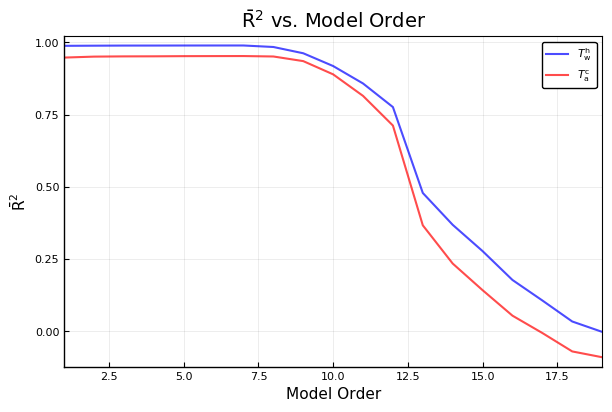

In [55]:
plot(results[1],results[6], label=L"$T_{\mathrm{w}}^{\mathrm{h}}$",lc=:blue,lw=LW2,ls=LS1,la=LA2)
plot!(results[1],results[7], label=L"$T_{\mathrm{a}}^{\mathrm{c}}$",lc=:red,lw=LW2,ls=LS1,la=LA2)
plot!(ylabel=L"$\bar{\mathrm{R}}^{2}$", xlabel="Model Order")
plot!(framestyle = :box,xlim =(1,length(results[1])),legend=:topright)
plot!(title=L"$\bar{\mathrm{R}}^{2}$ vs. Model Order")

figname = "R_bar_vs_Model_Order_case_3a.svg"
savefig(Figpath*figname)

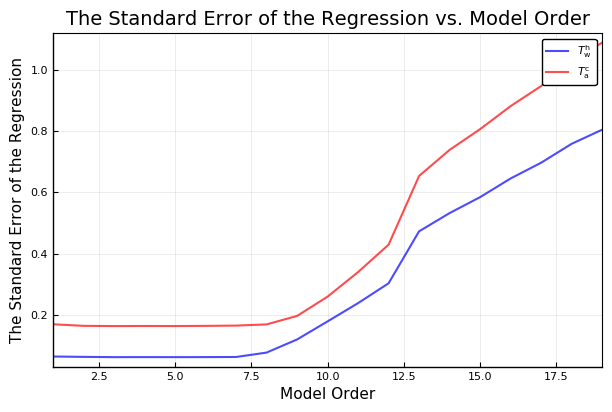

In [56]:
plot(results[1],results[3], label=L"$T_{\mathrm{w}}^{\mathrm{h}}$",lc=:blue,lw=LW2,ls=LS1,la=LA2)
plot!(results[1],results[4], label=L"$T_{\mathrm{a}}^{\mathrm{c}}$",lc=:red,lw=LW2,ls=LS1,la=LA2)
plot!(ylabel="The Standard Error of the Regression", xlabel="Model Order")
plot!(framestyle = :box,xlim =(1,length(results[1])),legend=:topright)
plot!(title="The Standard Error of the Regression vs. Model Order")

figname = "The_Standard_Error_of_the_Regression_vs_Model_Order_case_3a.svg"
savefig(Figpath*figname)

Based on the previous plots, three model orders will be considered to demonstrate the goodness of fit:
1. Model 1: 1st order
2. Model 2: 6th order
3. Model 3: 18th order

#### Plotting

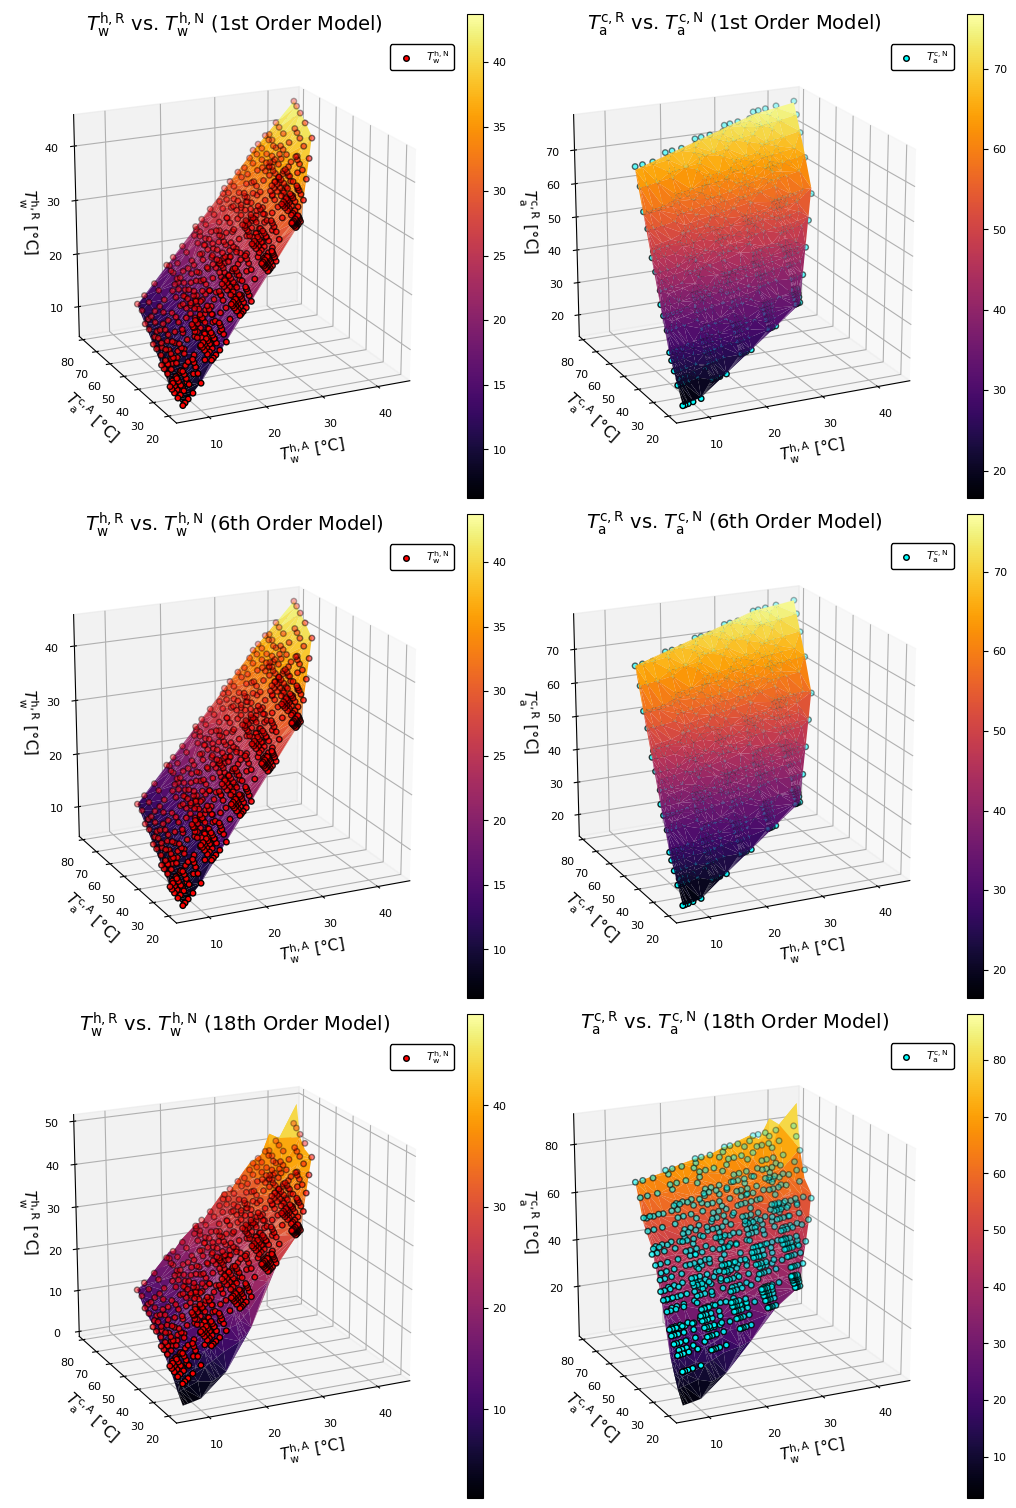

In [57]:
# 1st order
X = (phi_m.(mat2vec(TTAgrid_c3);n=1) |> x -> reduce(hcat,x))'  
Y = TTNgrid_c3';
β = X\Y
ŷ = X*β;
plot(TTAgrid_c3[1,:],TTAgrid_c3[2,:],ŷ[:,1],seriestype=:surface,xlabel=L"$T_{\mathrm{w}}^{\mathrm{h, A}}$ $[°\mathrm{C}]$", ylabel=L"$T_{\mathrm{a}}^{\mathrm{c, A}}$ $[°\mathrm{C}]$",zlabel=L"$T_{\mathrm{w}}^{\mathrm{h, R}}$ $[°\mathrm{C}]$")
fg1 = scatter!(TTAgrid_c3[1,:],TTAgrid_c3[2,:],Y[:,1],camera=(-25,20),label=L"$T_{\mathrm{w}}^{\mathrm{h, N}}$",title=L"$T_{\mathrm{w}}^{\mathrm{h, R}}$ vs. $T_{\mathrm{w}}^{\mathrm{h, N}}$ (1st Order Model)",color="red")
plot(TTAgrid_c3[1,:],TTAgrid_c3[2,:],ŷ[:,2],seriestype=:surface,xlabel=L"$T_{\mathrm{w}}^{\mathrm{h, A}}$ $[°\mathrm{C}]$", ylabel=L"$T_{\mathrm{a}}^{\mathrm{c, A}}$ $[°\mathrm{C}]$",zlabel=L"$T_{\mathrm{a}}^{\mathrm{c, R}}$ $[°\mathrm{C}]$")
fg2 = scatter!(TTAgrid_c3[1,:],TTAgrid_c3[2,:],Y[:,2],camera=(-25,20),label=L"$T_{\mathrm{a}}^{\mathrm{c, N}}$",title=L"$T_{\mathrm{a}}^{\mathrm{c, R}}$ vs. $T_{\mathrm{a}}^{\mathrm{c, N}}$ (1st Order Model)",color="#00FFFF")
#
# 6th order
#
X = (phi_m.(mat2vec(TTAgrid_c3);n=6) |> x -> reduce(hcat,x))'  
Y = TTNgrid_c3';
β = X\Y
ŷ = X*β;
plot(TTAgrid_c3[1,:],TTAgrid_c3[2,:],ŷ[:,1],seriestype=:surface,xlabel=L"$T_{\mathrm{w}}^{\mathrm{h, A}}$ $[°\mathrm{C}]$", ylabel=L"$T_{\mathrm{a}}^{\mathrm{c, A}}$ $[°\mathrm{C}]$",zlabel=L"$T_{\mathrm{w}}^{\mathrm{h, R}}$ $[°\mathrm{C}]$")
fg3 = scatter!(TTAgrid_c3[1,:],TTAgrid_c3[2,:],Y[:,1],camera=(-25,20),label=L"$T_{\mathrm{w}}^{\mathrm{h, N}}$",title=L"$T_{\mathrm{w}}^{\mathrm{h, R}}$ vs. $T_{\mathrm{w}}^{\mathrm{h, N}}$ (6th Order Model)",color="red")
plot(TTAgrid_c3[1,:],TTAgrid_c3[2,:],ŷ[:,2],seriestype=:surface,xlabel=L"$T_{\mathrm{w}}^{\mathrm{h, A}}$ $[°\mathrm{C}]$", ylabel=L"$T_{\mathrm{a}}^{\mathrm{c, A}}$ $[°\mathrm{C}]$",zlabel=L"$T_{\mathrm{a}}^{\mathrm{c, R}}$ $[°\mathrm{C}]$")
fg4 = scatter!(TTAgrid_c3[1,:],TTAgrid_c3[2,:],Y[:,2],camera=(-25,20),label=L"$T_{\mathrm{a}}^{\mathrm{c, N}}$",title=L"$T_{\mathrm{a}}^{\mathrm{c, R}}$ vs. $T_{\mathrm{a}}^{\mathrm{c, N}}$ (6th Order Model)",color="#00FFFF")
#
# 15th order
#
X = (phi_m.(mat2vec(TTAgrid_c3);n=12) |> x -> reduce(hcat,x))'  
Y = TTNgrid_c3';
β = X\Y
ŷ = X*β;
plot(TTAgrid_c3[1,:],TTAgrid_c3[2,:],ŷ[:,1],seriestype=:surface,xlabel=L"$T_{\mathrm{w}}^{\mathrm{h, A}}$ $[°\mathrm{C}]$", ylabel=L"$T_{\mathrm{a}}^{\mathrm{c, A}}$ $[°\mathrm{C}]$",zlabel=L"$T_{\mathrm{w}}^{\mathrm{h, R}}$ $[°\mathrm{C}]$")
fg5 = scatter!(TTAgrid_c3[1,:],TTAgrid_c3[2,:],Y[:,1],camera=(-25,20),label=L"$T_{\mathrm{w}}^{\mathrm{h, N}}$",title=L"$T_{\mathrm{w}}^{\mathrm{h, R}}$ vs. $T_{\mathrm{w}}^{\mathrm{h, N}}$ (18th Order Model)",color="red")
plot(TTAgrid_c3[1,:],TTAgrid_c3[2,:],ŷ[:,2],seriestype=:surface,xlabel=L"$T_{\mathrm{w}}^{\mathrm{h, A}}$ $[°\mathrm{C}]$", ylabel=L"$T_{\mathrm{a}}^{\mathrm{c, A}}$ $[°\mathrm{C}]$",zlabel=L"$T_{\mathrm{a}}^{\mathrm{c, R}}$ $[°\mathrm{C}]$")
fg6 = scatter!(TTAgrid_c3[1,:],TTAgrid_c3[2,:],Y[:,2],camera=(-25,20),label=L"$T_{\mathrm{a}}^{\mathrm{c, N}}$",title=L"$T_{\mathrm{a}}^{\mathrm{c, R}}$ vs. $T_{\mathrm{a}}^{\mathrm{c, N}}$ (18th Order Model)",color="#00FFFF")

plot(fg1,fg2,fg3,fg4,fg5,fg6,
    layout=grid(3,2),size = (1000, 1500),framestyle = :box,bottom_margin=10mm)
Figname = "Regression_of_1st_6th_18th_order_models_case_3a.svg"
savefig(Figpath*Figname)

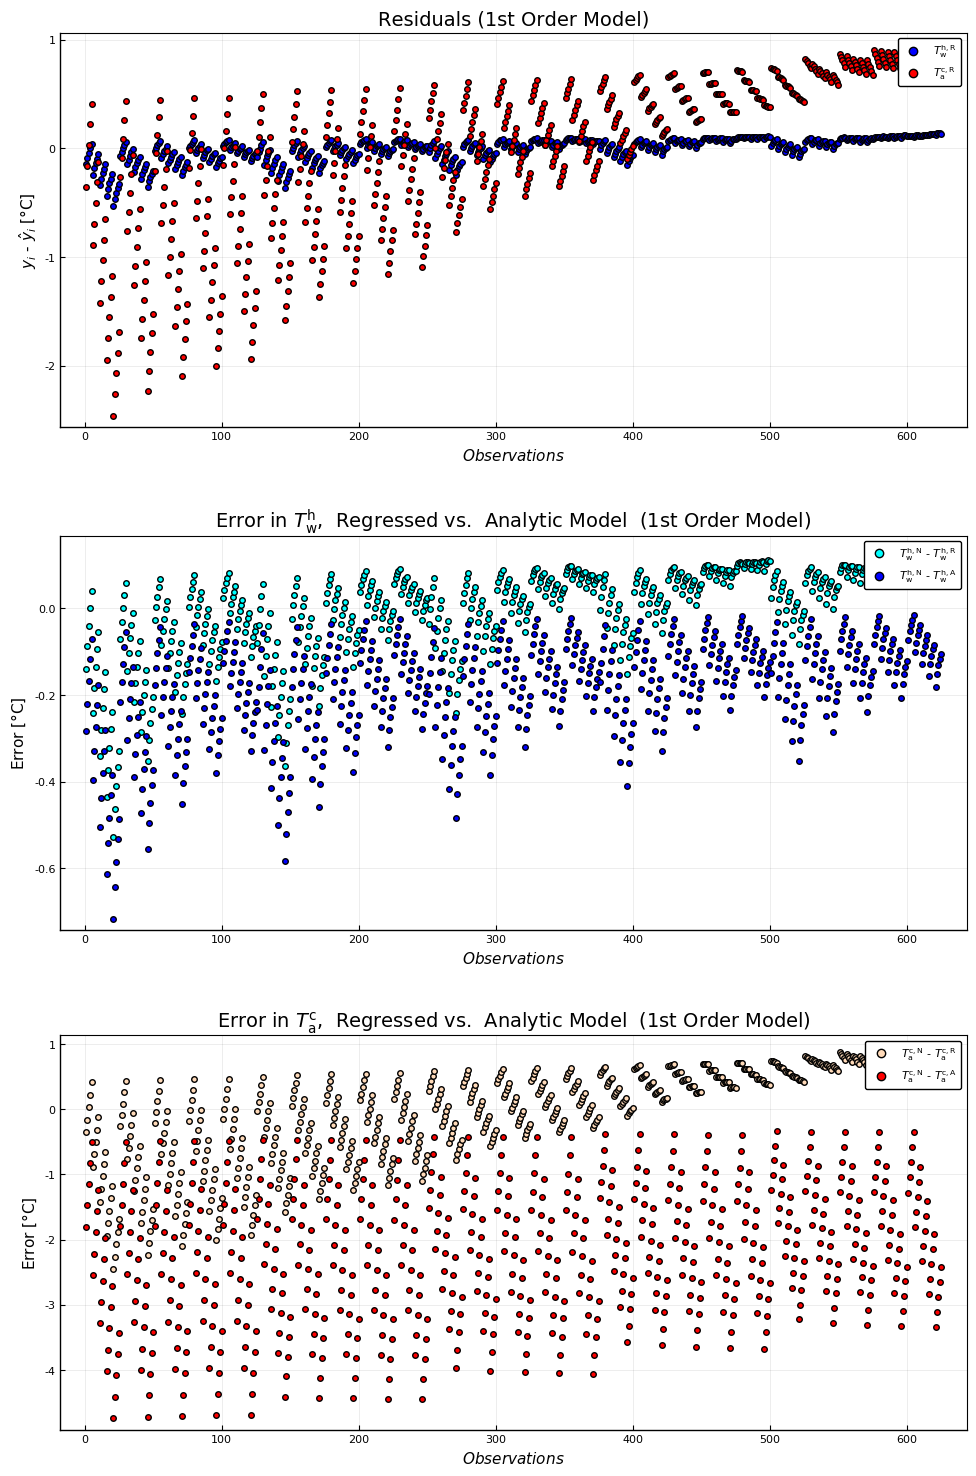

In [58]:
# 1st order
X = (phi_m.(mat2vec(TTAgrid_c3);n=1) |> x -> reduce(hcat,x))'  
Y = TTNgrid_c3';
β = X\Y
ŷ = X*β;

scatter((Y[:,1].-ŷ[:,1]),label=L"$T_{\mathrm{w}}^{\mathrm{h, R}}$",legend=:topright,color="blue")
scatter!((Y[:,2].-ŷ[:,2]),label=L"$T_{\mathrm{a}}^{\mathrm{c, R}}$",color="red")
fg1=plot!(title="Residuals (1st Order Model)",xlabel=L"Observations", ylabel=L"$y_{i}$ - $\hat{y}_{i}$ $[°\mathrm{C}]$")
scatter(Y[:,1].-ŷ[:,1], label=L"$T_{\mathrm{w}}^{\mathrm{h, N}}$ - $T_{\mathrm{w}}^{\mathrm{h, R}}$",legend=:topright,color="#00FFFF")
scatter!(Y[:,1].-TTAgrid_c3'[:,1], label=L"$T_{\mathrm{w}}^{\mathrm{h, N}}$ - $T_{\mathrm{w}}^{\mathrm{h, A}}$",color="blue")
fg2=plot!(title=L"Error in $T_{\mathrm{w}}^{\mathrm{h}}$,  Regressed vs.  Analytic Model  (1st Order Model)",xlabel=L"Observations",ylabel=L"Error $[°\mathrm{C}]$")
scatter(Y[:,2].-ŷ[:,2], label=L"$T_{\mathrm{a}}^{\mathrm{c, N}}$ - $T_{\mathrm{a}}^{\mathrm{c, R}}$",legend=:topright,color="#FFDAB9")
scatter!(Y[:,2].-TTAgrid_c3'[:,2], label=L"$T_{\mathrm{a}}^{\mathrm{c, N}}$ - $T_{\mathrm{a}}^{\mathrm{c, A}}$",color="red")
fg3=plot!(title=L"Error in $T_{\mathrm{a}}^{\mathrm{c}}$,  Regressed vs.  Analytic Model  (1st Order Model)",xlabel=L"Observations",ylabel=L"Error $[°\mathrm{C}]$")
plot(fg1,fg2,fg3,
    layout=grid(3,1),size = (1000, 1500),framestyle = :box,bottom_margin=10mm,right_margin=10mm)
Figname = "Regression_of_1st_order_models_case_3a.svg"
savefig(Figpath*Figname)

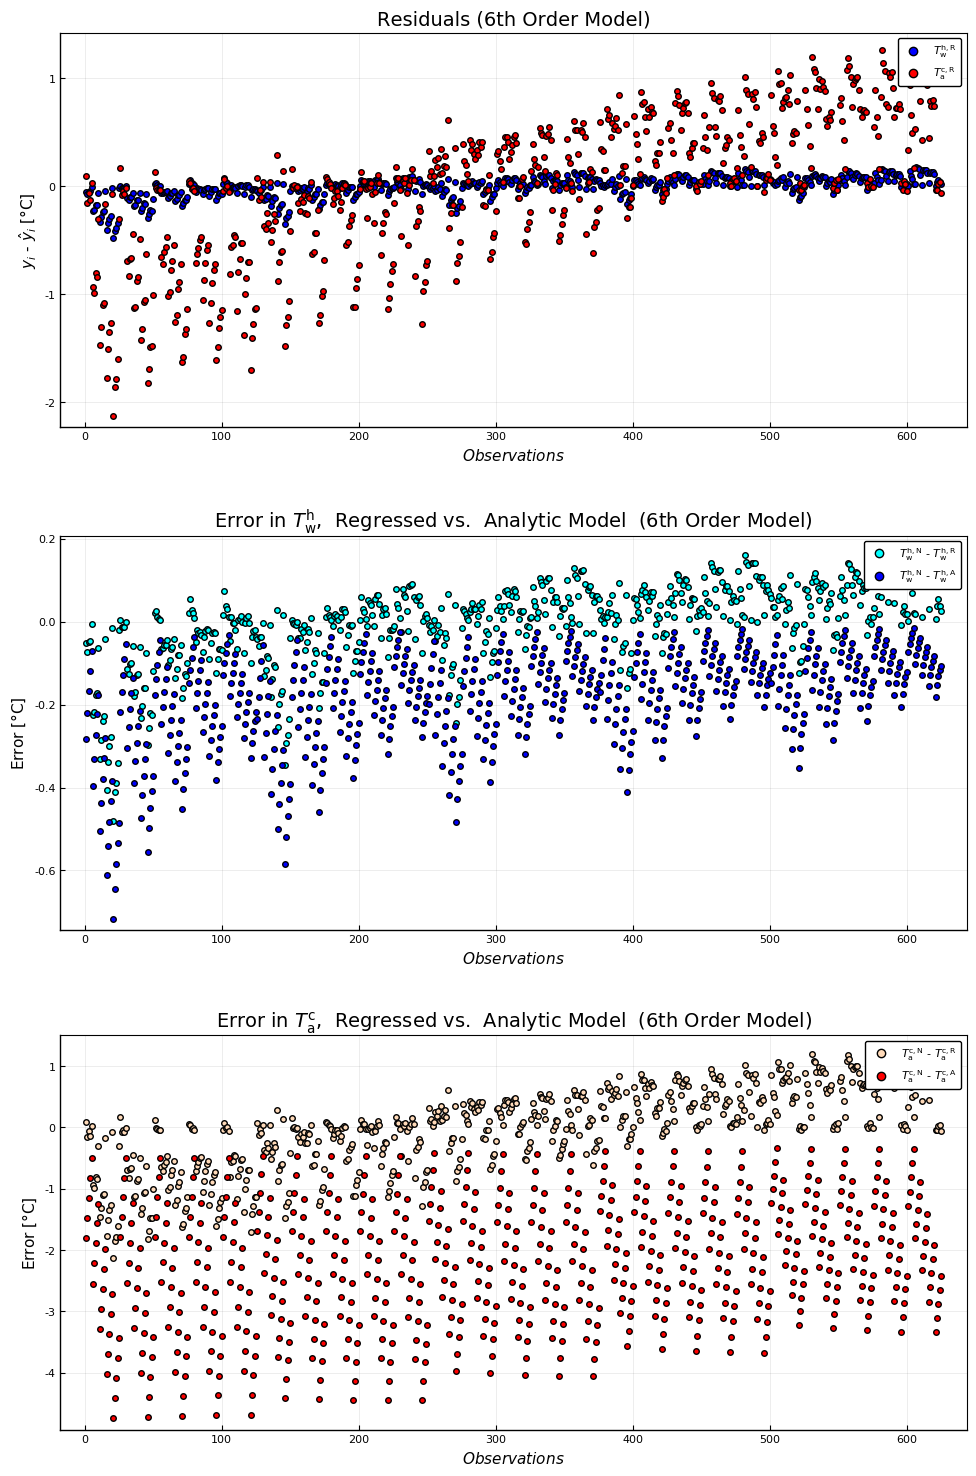

In [59]:
# 6th order
X = (phi_m.(mat2vec(TTAgrid_c3);n=6) |> x -> reduce(hcat,x))'  
Y = TTNgrid_c3';
β = X\Y
ŷ = X*β;

scatter((Y[:,1].-ŷ[:,1]),label=L"$T_{\mathrm{w}}^{\mathrm{h, R}}$",legend=:topright,color="blue")
scatter!((Y[:,2].-ŷ[:,2]),label=L"$T_{\mathrm{a}}^{\mathrm{c, R}}$",color="red")
fg1=plot!(title="Residuals (6th Order Model)",xlabel=L"Observations", ylabel=L"$y_{i}$ - $\hat{y}_{i}$ $[°\mathrm{C}]$")
scatter(Y[:,1].-ŷ[:,1], label=L"$T_{\mathrm{w}}^{\mathrm{h, N}}$ - $T_{\mathrm{w}}^{\mathrm{h, R}}$",legend=:topright,color="#00FFFF")
scatter!(Y[:,1].-TTAgrid_c3'[:,1], label=L"$T_{\mathrm{w}}^{\mathrm{h, N}}$ - $T_{\mathrm{w}}^{\mathrm{h, A}}$",color="blue")
fg2=plot!(title=L"Error in $T_{\mathrm{w}}^{\mathrm{h}}$,  Regressed vs.  Analytic Model  (6th Order Model)",xlabel=L"Observations",ylabel=L"Error $[°\mathrm{C}]$")
scatter(Y[:,2].-ŷ[:,2], label=L"$T_{\mathrm{a}}^{\mathrm{c, N}}$ - $T_{\mathrm{a}}^{\mathrm{c, R}}$",legend=:topright,color="#FFDAB9")
scatter!(Y[:,2].-TTAgrid_c3'[:,2], label=L"$T_{\mathrm{a}}^{\mathrm{c, N}}$ - $T_{\mathrm{a}}^{\mathrm{c, A}}$",color="red")
fg3=plot!(title=L"Error in $T_{\mathrm{a}}^{\mathrm{c}}$,  Regressed vs.  Analytic Model  (6th Order Model)",xlabel=L"Observations",ylabel=L"Error $[°\mathrm{C}]$")
plot(fg1,fg2,fg3,
    layout=grid(3,1),size = (1000, 1500),framestyle = :box,bottom_margin=10mm,right_margin=10mm)
Figname = "Regression_of_6th_order_models_case_3a.svg"
savefig(Figpath*Figname)

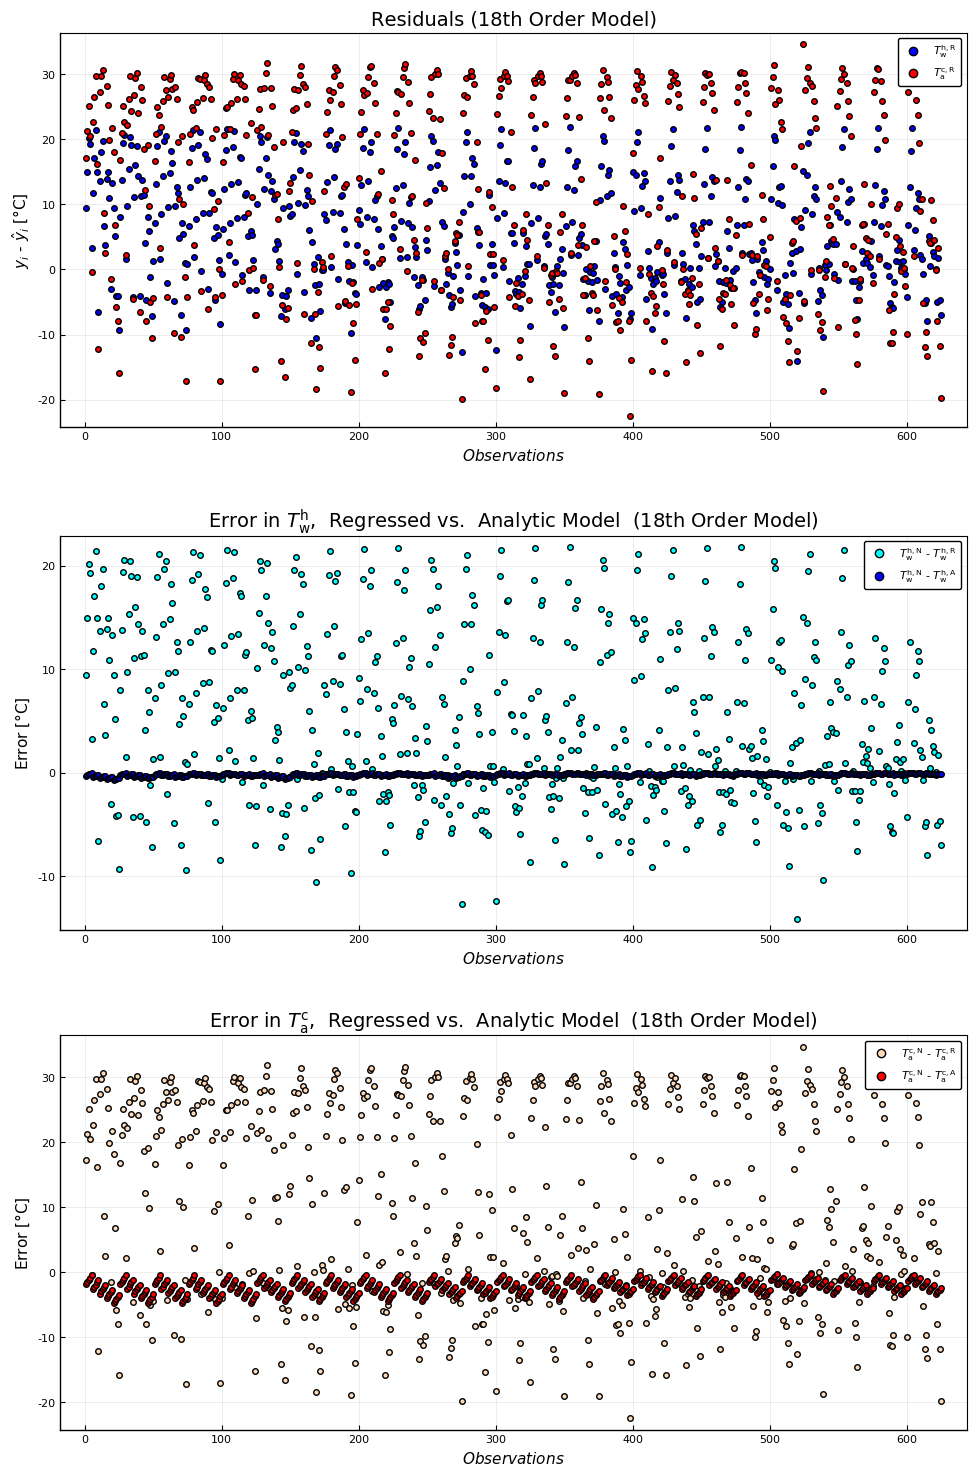

In [60]:
# 18th order
X = (phi_m.(mat2vec(TTAgrid_c3);n=18) |> x -> reduce(hcat,x))'  
Y = TTNgrid_c3';
β = X\Y
ŷ = X*β;

scatter((Y[:,1].-ŷ[:,1]),label=L"$T_{\mathrm{w}}^{\mathrm{h, R}}$",legend=:topright,color="blue")
scatter!((Y[:,2].-ŷ[:,2]),label=L"$T_{\mathrm{a}}^{\mathrm{c, R}}$",color="red")
fg1=plot!(title="Residuals (18th Order Model)",xlabel=L"Observations", ylabel=L"$y_{i}$ - $\hat{y}_{i}$ $[°\mathrm{C}]$")
scatter(Y[:,1].-ŷ[:,1], label=L"$T_{\mathrm{w}}^{\mathrm{h, N}}$ - $T_{\mathrm{w}}^{\mathrm{h, R}}$",legend=:topright,color="#00FFFF")
scatter!(Y[:,1].-TTAgrid_c3'[:,1], label=L"$T_{\mathrm{w}}^{\mathrm{h, N}}$ - $T_{\mathrm{w}}^{\mathrm{h, A}}$",color="blue")
fg2=plot!(title=L"Error in $T_{\mathrm{w}}^{\mathrm{h}}$,  Regressed vs.  Analytic Model  (18th Order Model)",xlabel=L"Observations",ylabel=L"Error $[°\mathrm{C}]$")
scatter(Y[:,2].-ŷ[:,2], label=L"$T_{\mathrm{a}}^{\mathrm{c, N}}$ - $T_{\mathrm{a}}^{\mathrm{c, R}}$",legend=:topright,color="#FFDAB9")
scatter!(Y[:,2].-TTAgrid_c3'[:,2], label=L"$T_{\mathrm{a}}^{\mathrm{c, N}}$ - $T_{\mathrm{a}}^{\mathrm{c, A}}$",color="red")
fg3=plot!(title=L"Error in $T_{\mathrm{a}}^{\mathrm{c}}$,  Regressed vs.  Analytic Model  (18th Order Model)",xlabel=L"Observations",ylabel=L"Error $[°\mathrm{C}]$")
plot(fg1,fg2,fg3,
    layout=grid(3,1),size = (1000, 1500),framestyle = :box,bottom_margin=10mm,right_margin=10mm)
Figname = "Regression_of_18th_order_models_case_3a.svg"
savefig(Figpath*Figname)

#### Validation
##### Model 1: 1st order

In [61]:
multiple_Holdout(TTAgrid_c3,TTNgrid_c3,1,ngrid,0.50,1000)

The average standard error of the regression for Y1: 0.0775944
The average standard error of the regression for Y2: 0.20320863

The average adjusted coefficient of determination for Y1: 0.98797304
The average adjusted coefficient of determination for Y2: 0.94702488

The average RMSE for Y1: 0.10555031
The average RMSE for Y2: 0.72372327


##### Model 2: 6th order

In [62]:
multiple_Holdout(TTAgrid_c3,TTNgrid_c3,6,ngrid,0.50,1000)

The average standard error of the regression for Y1: 0.07866278
The average standard error of the regression for Y2: 0.20599263

The average adjusted coefficient of determination for Y1: 0.98862523
The average adjusted coefficient of determination for Y2: 0.94991916

The average RMSE for Y1: 0.09975618
The average RMSE for Y2: 0.68380548


##### Model 3: 18th order

In [63]:
multiple_Holdout(TTAgrid_c3,TTNgrid_c3,18,ngrid,0.50,1000)

The average standard error of the regression for Y1: 2.82202043
The average standard error of the regression for Y2: 3.55549681

The average adjusted coefficient of determination for Y1: -4.03230806
The average adjusted coefficient of determination for Y2: -4.15195954

The average RMSE for Y1: 71.74191069
The average RMSE for Y2: 111.37147539


### Case III: (B) Same as the previous case, except that the mass flow rates are also regressors. Similarly, the goal here is to evaluate the impact of mass flow rate on the goodness-of-fit.
#### First, the sampling section of the multiple_Holdout function is modified to accommodate more regressors, and a new function is created `multiple_Holdout_case_3b`.

In [20]:
# This function runs the Holdout method multiple times (with )and returns an average of the standard error of the regression, RMSE, and R-bar
function multiple_Holdout_case_3b(TTAgrid,TTNgrid,order,ngrid,ratio,j)
    Std_Error_Array =  Array{Float64}(undef, j,3);
    R_bar_Array =  Array{Float64}(undef, j,2);
    RMSE_Array =  Array{Float64}(undef, j,2);
    for v in 1:j
        ############################# Sampling #############################
        #
        # Preparing the data set for sampling
        #
        Md_w_a = (hcat(TTAgrid'[:,3],TTAgrid'[:,4]))'
        Twh_A_N =(hcat(TTAgrid'[:,1],TTNgrid'[:,1]))'
        Tac_A_N =(hcat(TTAgrid'[:,2],TTNgrid'[:,2]))'
        #
        # Constructing training & testing samples indices
        #
        Train_index =  sort!(StatsBase.sample(1:ngrid, convert(Int64, round(ratio*ngrid)), replace=false))
        #
        Test_index = [i for i in 1:ngrid]
        for i in Train_index
            k = findall(x->x==i,Test_index)
            Test_index = Test_index[1:end .!= k, 1]
        end
        #
        # Constructing training & testing samples
        #
        Train_Sample_Md = Md_w_a[:,Train_index[:]]
        Test_Sample_Md = Md_w_a[:,Test_index[:]]
        Train_Sample_Twh = Twh_A_N[:,Train_index[:]]
        Train_Sample_Tac = Tac_A_N[:,Train_index[:]]
        Test_Sample_Twh = Twh_A_N[:,Test_index[:]]
        Test_Sample_Tac = Tac_A_N[:,Test_index[:]]
        #
        # Reconstructing TTAgrid & TTNgrid from samples
        #
        TTAgrid_Train_Sample=[Train_Sample_Md[1,:] Train_Sample_Md[2,:] Train_Sample_Twh[1,:] Train_Sample_Tac[1,:]]'
        TTNgrid_Train_Sample=[Train_Sample_Twh[2,:] Train_Sample_Tac[2,:]]'
        TTAgrid_Test_Sample=[Test_Sample_Md[1,:] Test_Sample_Md[2,:] Test_Sample_Twh[1,:] Test_Sample_Tac[1,:]]'
        TTNgrid_Test_Sample=[Test_Sample_Twh[2,:] Test_Sample_Tac[2,:]]'
        #
        ######################## Linear regression #########################
        #
        X = (phi_m.(mat2vec(TTAgrid_Train_Sample);n=order) |> x -> reduce(hcat,x))'  
        Y = TTNgrid_Train_Sample';
        β = X\Y
        #
        # Prediction
        #
        X_test = (phi_m.(mat2vec(TTAgrid_Test_Sample);n=order) |> x -> reduce(hcat,x))'
        ŷ = X_test*β
        Y_test = TTNgrid_Test_Sample'
        #
        # measure of goodness-of-fit using the adjusted R-squared, the standard error of the regression, and RMSE.
        #
        df_RSS = (length(Test_index) - size(β)[1])
        df_TSS = (length(Test_index) - 1)
        #
        RSS_1 = norm(Y_test[:,1].-ŷ[:,1])
        TSS_1 = norm(Y_test[:,1].-mean(ŷ[:,1]))     
        Std_Error_1 = sqrt(RSS_1/df_RSS)
        R_squared_1 = 1 - (RSS_1/TSS_1)
        R_bar_1 = 1 - (1-R_squared_1)*(df_TSS/df_TSS)
        #
        RSS_2 = norm(Y_test[:,2].-ŷ[:,2])
        TSS_2 = norm(Y_test[:,2].-mean(ŷ[:,2]))  
        Std_Error_2 = sqrt(RSS_2/df_RSS)
        R_squared_2 = 1 - (RSS_2/TSS_2)
        R_bar_2 = 1 - (1-R_squared_2)*(df_TSS/df_TSS)
        #
        #
        #
        Std_Error_Array[v,1] = df_RSS
        Std_Error_Array[v,2] = Std_Error_1
        Std_Error_Array[v,3] = Std_Error_2       
        R_bar_Array[v,1] = R_bar_1
        R_bar_Array[v,2] = R_bar_2
        RMSE_Array[v,1]=RMSE(Y_test[:,1],ŷ[:,1])
        RMSE_Array[v,2]=RMSE(Y_test[:,2],ŷ[:,2])
    end
     avg_Std_Error_1 = round(sum(Std_Error_Array[:,2])/j; digits=8)
     avg_Std_Error_2 = round(sum(Std_Error_Array[:,3])/j; digits=8)
     avg_R_bar_1 = round(sum(R_bar_Array[:,1])/j; digits=8)
     avg_R_bar_2 = round(sum(R_bar_Array[:,2])/j; digits=8)
     avg_RMSE_1 = round(sum(RMSE_Array[:,1])/j; digits=8)
     avg_RMSE_2 = round(sum(RMSE_Array[:,2])/j; digits=8)
   return println("The average standard error of the regression for Y1: ", avg_Std_Error_1,"\nThe average standard error of the regression for Y2: ", avg_Std_Error_2,
        "\n\nThe average adjusted coefficient of determination for Y1: ", avg_R_bar_1,"\nThe average adjusted coefficient of determination for Y2: ", avg_R_bar_2,
    "\n\nThe average RMSE for Y1: ", avg_RMSE_1,"\nThe average RMSE for Y2: ", avg_RMSE_2)
end
;

#### Generating the dataset: The datasets are generated in a wider range as in the case of 3.c

In [12]:
# Experimental ranges
n_Tw = 10
n_Ta = 10
n_mdw = 10
n_mda = 10
ngrid = n_Tw*n_Ta*n_mdw*n_mda
#
r_Twc = range(4.,40.,length=n_Tw)
r_Tah = range(15.,130.,length=n_Ta)
r_mdw = range(15.,130.,length=n_mdw)
r_mda = range(15.,130.,length=n_mda)
#
T_md_grid = [[Twc,Tah,mdw,mda] for Twc in r_Twc, Tah in r_Tah, mdw in r_mdw, mda in r_mda]
TTAgrid_c3_b = Matrix{Float64}(undef,4,ngrid) # dimension 2xngrid
TTNgrid_c3_b = Matrix{Float64}(undef,2,ngrid);

In [13]:
# Solving model for all inputs
@showprogress for i in 1:ngrid
    sleep(0.1)
    Twc,Tah,mdw,mda = T_md_grid[i]
    u_hex = [Twc  Tah  mdw  mda]        
    sol_analytic = map(dx -> hex_a(u_hex, par_hex_a, dx), xspan_a)
    TTAgrid_c3_b[:,i] .= [sol_analytic[end][1],sol_analytic[1][end],mdw,mda]
    sol_numeric = hex_n(u_hex, par_hex_n, xspan_n)
    TTNgrid_c3_b[:,i] .= [sol_numeric[end][1],sol_numeric[1][end]]
end

Progress: 100%|█████████████████████████████████████████| Time: 0:22:55m12


#### Find the best fit degree/order of the model using the standard error of the regression and $\bar{\mathrm{R}}^{2}$

In [78]:
results = goodness_of_fit(TTAgrid_c3_b,TTNgrid_c3_b,8) |> mat2vec;

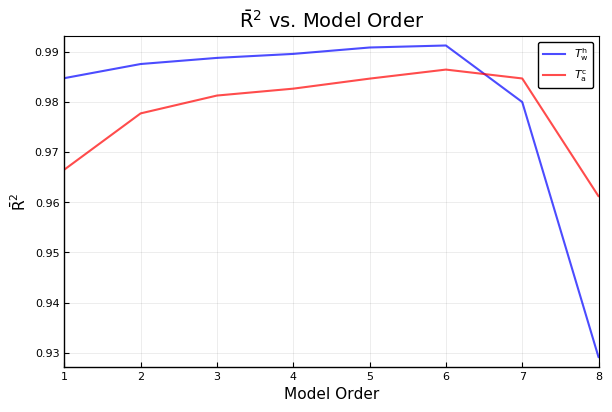

In [79]:
plot(results[1],results[6], label=L"$T_{\mathrm{w}}^{\mathrm{h}}$",lc=:blue,lw=LW2,ls=LS1,la=LA2)
plot!(results[1],results[7], label=L"$T_{\mathrm{a}}^{\mathrm{c}}$",lc=:red,lw=LW2,ls=LS1,la=LA2)
plot!(ylabel=L"$\bar{\mathrm{R}}^{2}$", xlabel="Model Order")
plot!(framestyle = :box,xlim =(1,length(results[1])),legend=:topright)
plot!(title=L"$\bar{\mathrm{R}}^{2}$ vs. Model Order")

figname = "R_bar_vs_Model_Order_case_3b.svg"
savefig(Figpath*figname)

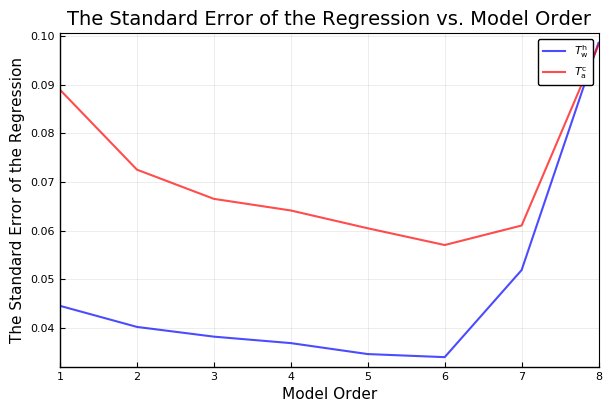

In [80]:
plot(results[1],results[3], label=L"$T_{\mathrm{w}}^{\mathrm{h}}$",lc=:blue,lw=LW2,ls=LS1,la=LA2)
plot!(results[1],results[4], label=L"$T_{\mathrm{a}}^{\mathrm{c}}$",lc=:red,lw=LW2,ls=LS1,la=LA2)
plot!(ylabel="The Standard Error of the Regression", xlabel="Model Order")
plot!(framestyle = :box,xlim =(1,length(results[1])),legend=:topright)
plot!(title="The Standard Error of the Regression vs. Model Order")

figname = "The_Standard_Error_of_the_Regression_vs_Model_Order_case_3b.svg"
savefig(Figpath*figname)

Based on the previous plots, two model orders will be considered to demonstrate the goodness of fit:
1. Model 1: 1st order
2. Model 2: 6th order

#### Plotting

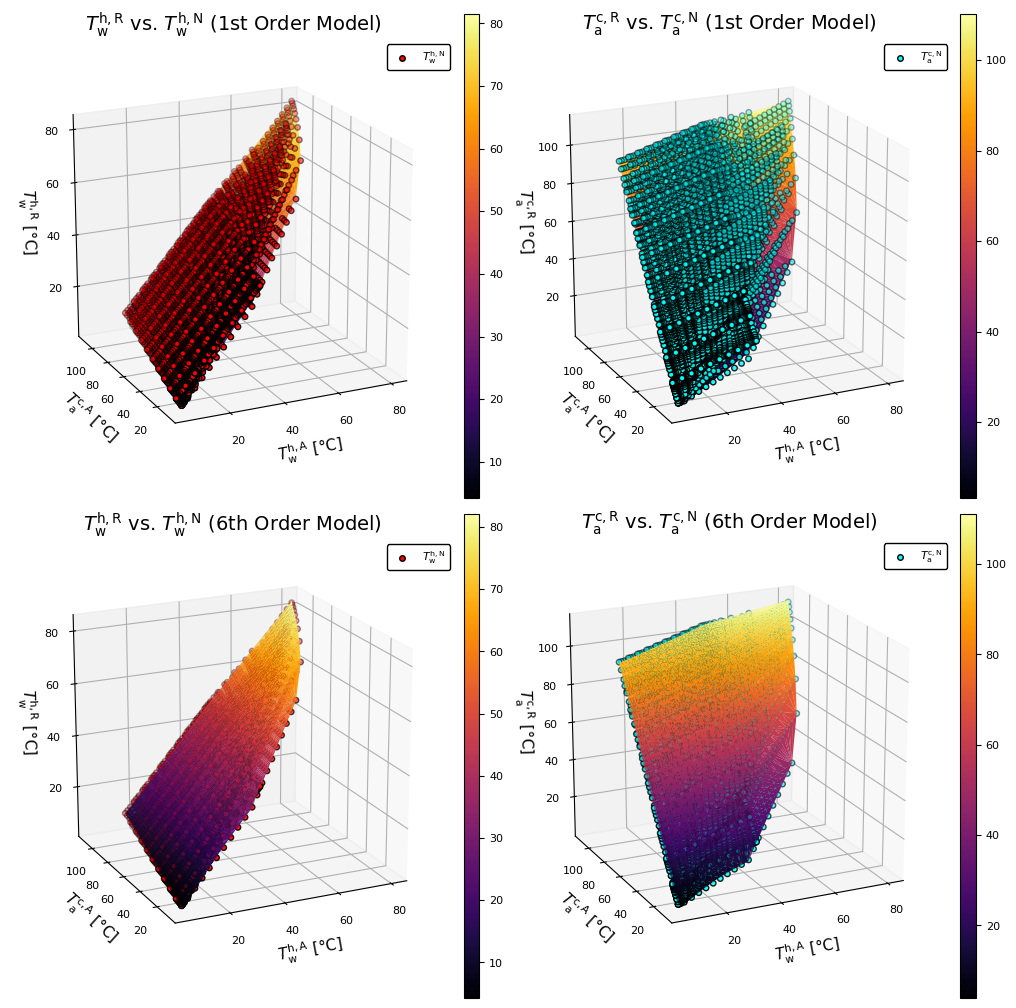

In [81]:
# 1st order
X = (phi_m.(mat2vec(TTAgrid_c3_b);n=1) |> x -> reduce(hcat,x))'  
Y = TTNgrid_c3_b';
β = X\Y
ŷ = X*β;
plot(TTAgrid_c3_b[1,:],TTAgrid_c3_b[2,:],ŷ[:,1],seriestype=:surface,xlabel=L"$T_{\mathrm{w}}^{\mathrm{h, A}}$ $[°\mathrm{C}]$", ylabel=L"$T_{\mathrm{a}}^{\mathrm{c, A}}$ $[°\mathrm{C}]$",zlabel=L"$T_{\mathrm{w}}^{\mathrm{h, R}}$ $[°\mathrm{C}]$")
fg1 = scatter!(TTAgrid_c3_b[1,:],TTAgrid_c3_b[2,:],Y[:,1],camera=(-25,20),label=L"$T_{\mathrm{w}}^{\mathrm{h, N}}$",title=L"$T_{\mathrm{w}}^{\mathrm{h, R}}$ vs. $T_{\mathrm{w}}^{\mathrm{h, N}}$ (1st Order Model)",color="red")
plot(TTAgrid_c3_b[1,:],TTAgrid_c3_b[2,:],ŷ[:,2],seriestype=:surface,xlabel=L"$T_{\mathrm{w}}^{\mathrm{h, A}}$ $[°\mathrm{C}]$", ylabel=L"$T_{\mathrm{a}}^{\mathrm{c, A}}$ $[°\mathrm{C}]$",zlabel=L"$T_{\mathrm{a}}^{\mathrm{c, R}}$ $[°\mathrm{C}]$")
fg2 = scatter!(TTAgrid_c3_b[1,:],TTAgrid_c3_b[2,:],Y[:,2],camera=(-25,20),label=L"$T_{\mathrm{a}}^{\mathrm{c, N}}$",title=L"$T_{\mathrm{a}}^{\mathrm{c, R}}$ vs. $T_{\mathrm{a}}^{\mathrm{c, N}}$ (1st Order Model)",color="#00FFFF")
#
# 6th order
#
X = (phi_m.(mat2vec(TTAgrid_c3_b);n=6) |> x -> reduce(hcat,x))'  
Y = TTNgrid_c3_b';
β = X\Y
ŷ = X*β;
plot(TTAgrid_c3_b[1,:],TTAgrid_c3_b[2,:],ŷ[:,1],seriestype=:surface,xlabel=L"$T_{\mathrm{w}}^{\mathrm{h, A}}$ $[°\mathrm{C}]$", ylabel=L"$T_{\mathrm{a}}^{\mathrm{c, A}}$ $[°\mathrm{C}]$",zlabel=L"$T_{\mathrm{w}}^{\mathrm{h, R}}$ $[°\mathrm{C}]$")
fg3 = scatter!(TTAgrid_c3_b[1,:],TTAgrid_c3_b[2,:],Y[:,1],camera=(-25,20),label=L"$T_{\mathrm{w}}^{\mathrm{h, N}}$",title=L"$T_{\mathrm{w}}^{\mathrm{h, R}}$ vs. $T_{\mathrm{w}}^{\mathrm{h, N}}$ (6th Order Model)",color="red")
plot(TTAgrid_c3_b[1,:],TTAgrid_c3_b[2,:],ŷ[:,2],seriestype=:surface,xlabel=L"$T_{\mathrm{w}}^{\mathrm{h, A}}$ $[°\mathrm{C}]$", ylabel=L"$T_{\mathrm{a}}^{\mathrm{c, A}}$ $[°\mathrm{C}]$",zlabel=L"$T_{\mathrm{a}}^{\mathrm{c, R}}$ $[°\mathrm{C}]$")
fg4 = scatter!(TTAgrid_c3_b[1,:],TTAgrid_c3_b[2,:],Y[:,2],camera=(-25,20),label=L"$T_{\mathrm{a}}^{\mathrm{c, N}}$",title=L"$T_{\mathrm{a}}^{\mathrm{c, R}}$ vs. $T_{\mathrm{a}}^{\mathrm{c, N}}$ (6th Order Model)",color="#00FFFF")
#
plot(fg1,fg2,fg3,fg4,
    layout=grid(2,2),size = (1000, 1000),framestyle = :box,bottom_margin=10mm)
Figname = "Regression_of_1st_6th_order_models_case_3b.svg"
savefig(Figpath*Figname)

#### Validation
##### Model 1: 1st order

In [74]:
multiple_Holdout_case_3b(TTAgrid_c3_b2,TTNgrid_c3_b2,1,ngrid,0.50,1000)

The average standard error of the regression for Y1: 0.05293457
The average standard error of the regression for Y2: 0.10581149

The average adjusted coefficient of determination for Y1: 0.98482044
The average adjusted coefficient of determination for Y2: 0.96653181

The average RMSE for Y1: 0.19796433
The average RMSE for Y2: 0.79091089


##### Model 2: 6th order

In [75]:
multiple_Holdout_case_3b(TTAgrid_c3_b2,TTNgrid_c3_b2,6,ngrid,0.50,1000)

The average standard error of the regression for Y1: 0.04148825
The average standard error of the regression for Y2: 0.06945538

The average adjusted coefficient of determination for Y1: 0.99105622
The average adjusted coefficient of determination for Y2: 0.98617308

The average RMSE for Y1: 0.11662211
The average RMSE for Y2: 0.32683733


### Case III: (C) Same as case (3.a), except data is generated for a wider range. The goal here is to compare the goodness of fit with nonlinear regression later on.
#### Generating the dataset

In [72]:
# Experimental ranges
n_Tw = 10
n_Ta = 10
n_mdw = 10
n_mda = 10
ngrid = n_Tw*n_Ta*n_mdw*n_mda
#
r_Twc = range(4.,40.,length=n_Tw)
r_Tah = range(15.,130.,length=n_Ta)
r_mdw = range(15.,130.,length=n_mdw)
r_mda = range(15.,130.,length=n_mda)
#
T_md_grid = [[Twc,Tah,mdw,mda] for Twc in r_Twc, Tah in r_Tah, mdw in r_mdw, mda in r_mda]
TTAgrid_c3_c = Matrix{Float64}(undef,2,ngrid) # dimension 2xngrid
TTNgrid_c3_c = Matrix{Float64}(undef,2,ngrid)
;

In [73]:
# Solving model for all inputs
@showprogress for i in 1:ngrid
    sleep(0.1)
    Twc,Tah,mdw,mda = T_md_grid[i]
    u_hex = [Twc  Tah  mdw  mda]        
    sol_analytic = map(dx -> hex_a(u_hex, par_hex_a, dx), xspan_a)
    TTAgrid_c3_c[:,i] .= [sol_analytic[end][1],sol_analytic[1][end]] #### Note: Sol[row][column] #### Each loop fill 1 column.Notice ".=" 
    sol_numeric = hex_n(u_hex, par_hex_n, xspan_n)
    TTNgrid_c3_c[:,i] .= [sol_numeric[end][1],sol_numeric[1][end]]
end

Progress: 100%|█████████████████████████████████████████| Time: 0:23:25


#### Find the best fit degree/order of the model using the standard error of the regression and $\bar{\mathrm{R}}^{2}$

In [74]:
results = goodness_of_fit(TTAgrid_c3_c,TTNgrid_c3_c,19) |> mat2vec;

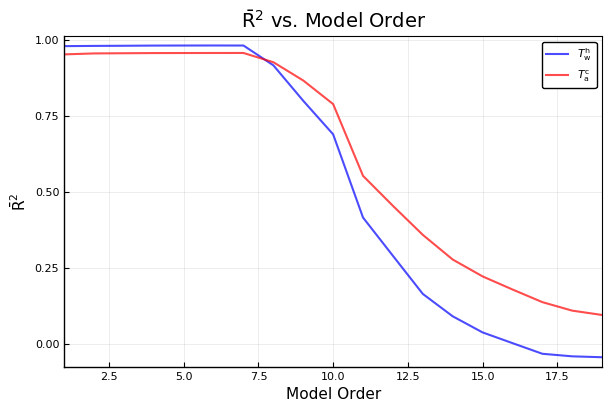

In [75]:
plot(results[1],results[6], label=L"$T_{\mathrm{w}}^{\mathrm{h}}$",lc=:blue,lw=LW2,ls=LS1,la=LA2)
plot!(results[1],results[7], label=L"$T_{\mathrm{a}}^{\mathrm{c}}$",lc=:red,lw=LW2,ls=LS1,la=LA2)
plot!(ylabel=L"$\bar{\mathrm{R}}^{2}$", xlabel="Model Order")
plot!(framestyle = :box,xlim =(1,length(results[1])),legend=:topright)
plot!(title=L"$\bar{\mathrm{R}}^{2}$ vs. Model Order")

figname = "R_bar_vs_Model_Order_case_3c.svg"
savefig(Figpath*figname)

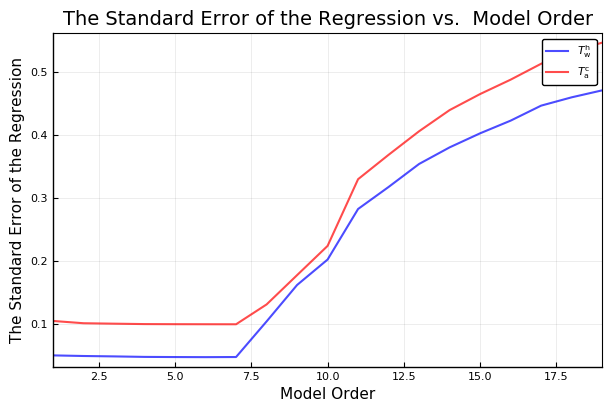

In [76]:
plot(results[1],results[3], label=L"$T_{\mathrm{w}}^{\mathrm{h}}$",lc=:blue,lw=LW2,ls=LS1,la=LA2)
plot!(results[1],results[4], label=L"$T_{\mathrm{a}}^{\mathrm{c}}$",lc=:red,lw=LW2,ls=LS1,la=LA2)
plot!(ylabel="The Standard Error of the Regression", xlabel="Model Order")
plot!(framestyle = :box,xlim =(1,length(results[1])),legend=:topright)
plot!(title="The Standard Error of the Regression vs.  Model Order")

figname = "The_Standard_Error_of_the_Regression_vs_Model_Order_case_3c.svg"
savefig(Figpath*figname)

#### Validation
##### Model 1: 1st order

In [77]:
multiple_Holdout(TTAgrid_c3_c,TTNgrid_c3_c,1,ngrid,0.50,100)

The average standard error of the regression for Y1: 0.05941832
The average standard error of the regression for Y2: 0.12447671

The average adjusted coefficient of determination for Y1: 0.98087158
The average adjusted coefficient of determination for Y2: 0.9536708

The average RMSE for Y1: 0.24952088
The average RMSE for Y2: 1.09498773


##### Model 2: 6th order

In [78]:
multiple_Holdout(TTAgrid_c3_c,TTNgrid_c3_c,6,ngrid,0.50,1000)

The average standard error of the regression for Y1: 0.05634448
The average standard error of the regression for Y2: 0.11860076

The average adjusted coefficient of determination for Y1: 0.98288539
The average adjusted coefficient of determination for Y2: 0.95815315

The average RMSE for Y1: 0.22325409
The average RMSE for Y2: 0.98907569


## Case 4: A lower order model is considered to improve the simulation time in "Comparison of the Execution Speed of the Hybrid Non-Ideal Heat Exchanger Model and the Numeric Solver" Jupyter Notebook.
A second-order model can give better results and faster execution speed.

In [12]:
# Experimental ranges
n_Tw = 10
n_Ta = 10
n_mdw = 10
n_mda = 10
ngrid = n_Tw*n_Ta*n_mdw*n_mda
#
r_Twc = range(3.,25.,length=n_Tw)
r_Tah = range(15.,100.,length=n_Ta)
r_mdw = range(30.,70.,length=n_mdw)
r_mda = range(30.,70.,length=n_mda)
#
T_md_grid = [[Twc,Tah,mdw,mda] for Twc in r_Twc, Tah in r_Tah, mdw in r_mdw, mda in r_mda]
TTAgrid_c3_b_test = Matrix{Float64}(undef,4,ngrid) # dimension 2xngrid
TTNgrid_c3_b_test = Matrix{Float64}(undef,2,ngrid);

In [13]:
# Solving model for all inputs
@showprogress for i in 1:ngrid
    sleep(0.1)
    Twc,Tah,mdw,mda = T_md_grid[i]
    u_hex = [Twc  Tah  mdw  mda]        
    sol_analytic = map(dx -> hex_a(u_hex, par_hex_a, dx), xspan_a)
    TTAgrid_c3_b_test[:,i] .= [sol_analytic[end][1],sol_analytic[1][end],mdw,mda]
    sol_numeric = hex_n(u_hex, par_hex_n, xspan_n)
    TTNgrid_c3_b_test[:,i] .= [sol_numeric[end][1],sol_numeric[1][end]]
end

Progress: 100%|█████████████████████████████████████████| Time: 0:23:03m42


In [21]:
multiple_Holdout_case_3b(TTAgrid_c3_b_test,TTNgrid_c3_b_test,1,ngrid,0.50,1000)

The average standard error of the regression for Y1: 0.03429471
The average standard error of the regression for Y2: 0.0749979

The average adjusted coefficient of determination for Y1: 0.98881012
The average adjusted coefficient of determination for Y2: 0.97026515

The average RMSE for Y1: 0.08308445
The average RMSE for Y2: 0.39733543


In [24]:
multiple_Holdout_case_3b(TTAgrid_c3_b_test,TTNgrid_c3_b_test,2,ngrid,0.50,1000)

The average standard error of the regression for Y1: 0.02280075
The average standard error of the regression for Y2: 0.0437051

The average adjusted coefficient of determination for Y1: 0.99506223
The average adjusted coefficient of determination for Y2: 0.9899226

The average RMSE for Y1: 0.03665342
The average RMSE for Y2: 0.13466842


In [31]:
X = (phi_m.(mat2vec(TTAgrid_c3_b_test);n=2) |> x -> reduce(hcat,x))'  
Y = TTNgrid_c3_b_test';
β2 = X\Y

15×2 Array{Float64,2}:
 -1.46764      -4.9438
  1.06458       0.343514
 -0.0654394     0.64369
  0.024763      0.0600815
  0.0347092     0.144819
 -0.000131071   4.16936e-5
  7.98482e-5   -0.000201377
 -0.000360431  -0.000719295
 -0.000480397  -0.00304375
  1.5105e-5     0.000160675
  0.000367366   0.000816647
  0.000510461   0.00317193
 -0.000139781  -0.000343265
 -0.000200468  -0.00050214
 -0.000240492  -0.00116976